In [2]:
import nltk
import gensim
import gensim.corpora as corpora
import pandas as pd
import numpy as np
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.vectorizers import ClassTfidfTransformer
from gensim.models.coherencemodel import CoherenceModel
from bertopic.representation import KeyBERTInspired
from bertopic.representation import PartOfSpeech
df = pd.read_csv("cleaned_file.csv")
dataset = df.Column1.tolist()

nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

filtered_text = []
lemmatizer = WordNetLemmatizer()

for w in dataset:
  filtered_text.append(lemmatizer.lemmatize(w))
# print(filtered_text[:1])

# Step 2.1 - Extract embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Step 2.2 - Reduce dimensionality   n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine'
umap_model = UMAP(n_neighbors=150, n_components=5, min_dist=0.0, metric='cosine', random_state=42)

# Step 2.3 - Cluster reduced embeddings    min_cluster_size=15, metric='euclidean', cluster_selection_method='eom', prediction_data=True
hdbscan_model = HDBSCAN(min_cluster_size=50, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

# Step 2.4 - Tokenize topics    stop_words="english"
vectorizer_model = CountVectorizer(stop_words="english", min_df=2, ngram_range=(1, 2))

# Step 2.5 - Create topic representation
ctfidf_model = ClassTfidfTransformer()

# Step 6 - (Optional) Fine-tune topic representations with 
# a `bertopic.representation` model
representation_model = PartOfSpeech("en_core_web_sm")

topic_model = BERTopic(
  embedding_model=embedding_model,    # Step 1 - Extract embeddings
  umap_model=umap_model,              # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,        # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,  # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model,          # Step 5 - Extract topic words   6   
  representation_model=representation_model,
  verbose=True
  
)

topics, probabilities = topic_model.fit_transform(filtered_text)

# topic_model.get_topic_info()

# topic_model.get_topic_info().to_csv('topics_TestPlus2.csv', index=False)

new_topics = topic_model.reduce_outliers(filtered_text, topics)

vectorizer_model = CountVectorizer(stop_words="english", min_df=2, ngram_range=(1, 2))
representation_model = PartOfSpeech("en_core_web_sm")
# topic_model.update_topics(docs, vectorizer_model=vectorizer_model)
topic_model.update_topics(filtered_text, topics=new_topics, vectorizer_model=vectorizer_model, representation_model=representation_model)

topic_model.get_topic_info().to_csv('topics_Fianl_pub.csv', index=False)
topic_model.get_document_info(filtered_text).to_csv('FulDoc_Final_pub.csv', index=False)


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Sia\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Sia\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Sia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


OSError: [E050] Can't find model 'en_core_web_sm'. It doesn't seem to be a Python package or a valid path to a data directory.

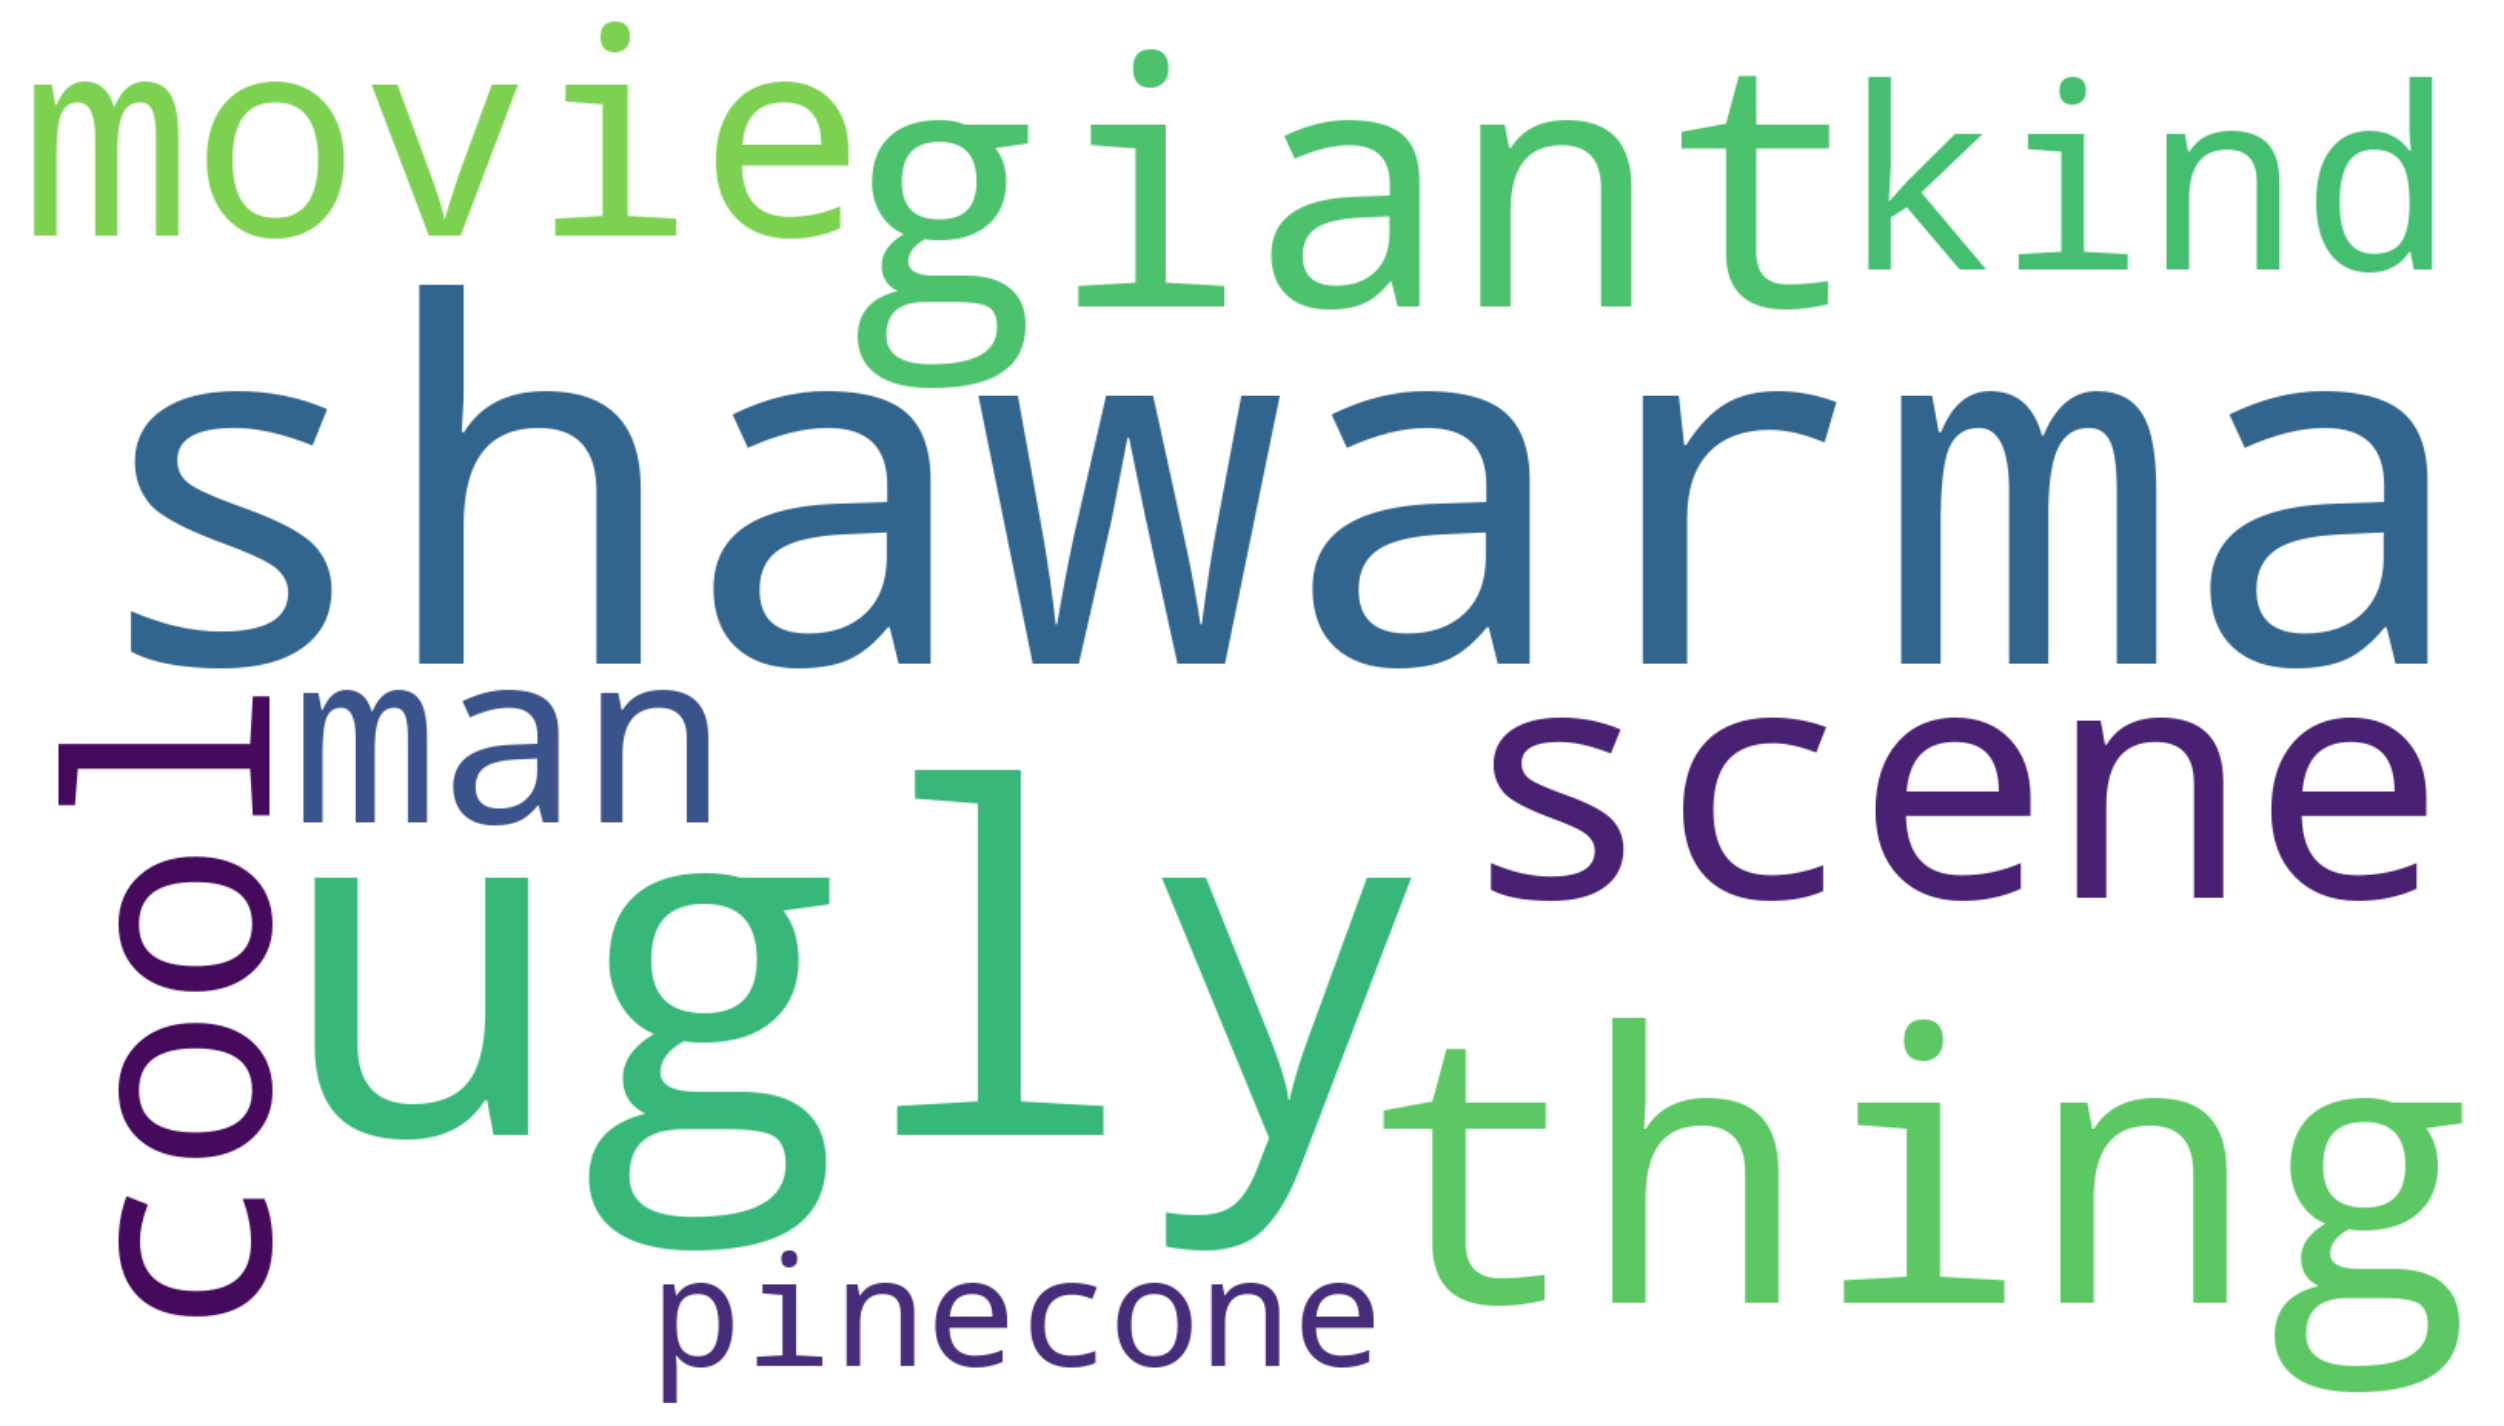

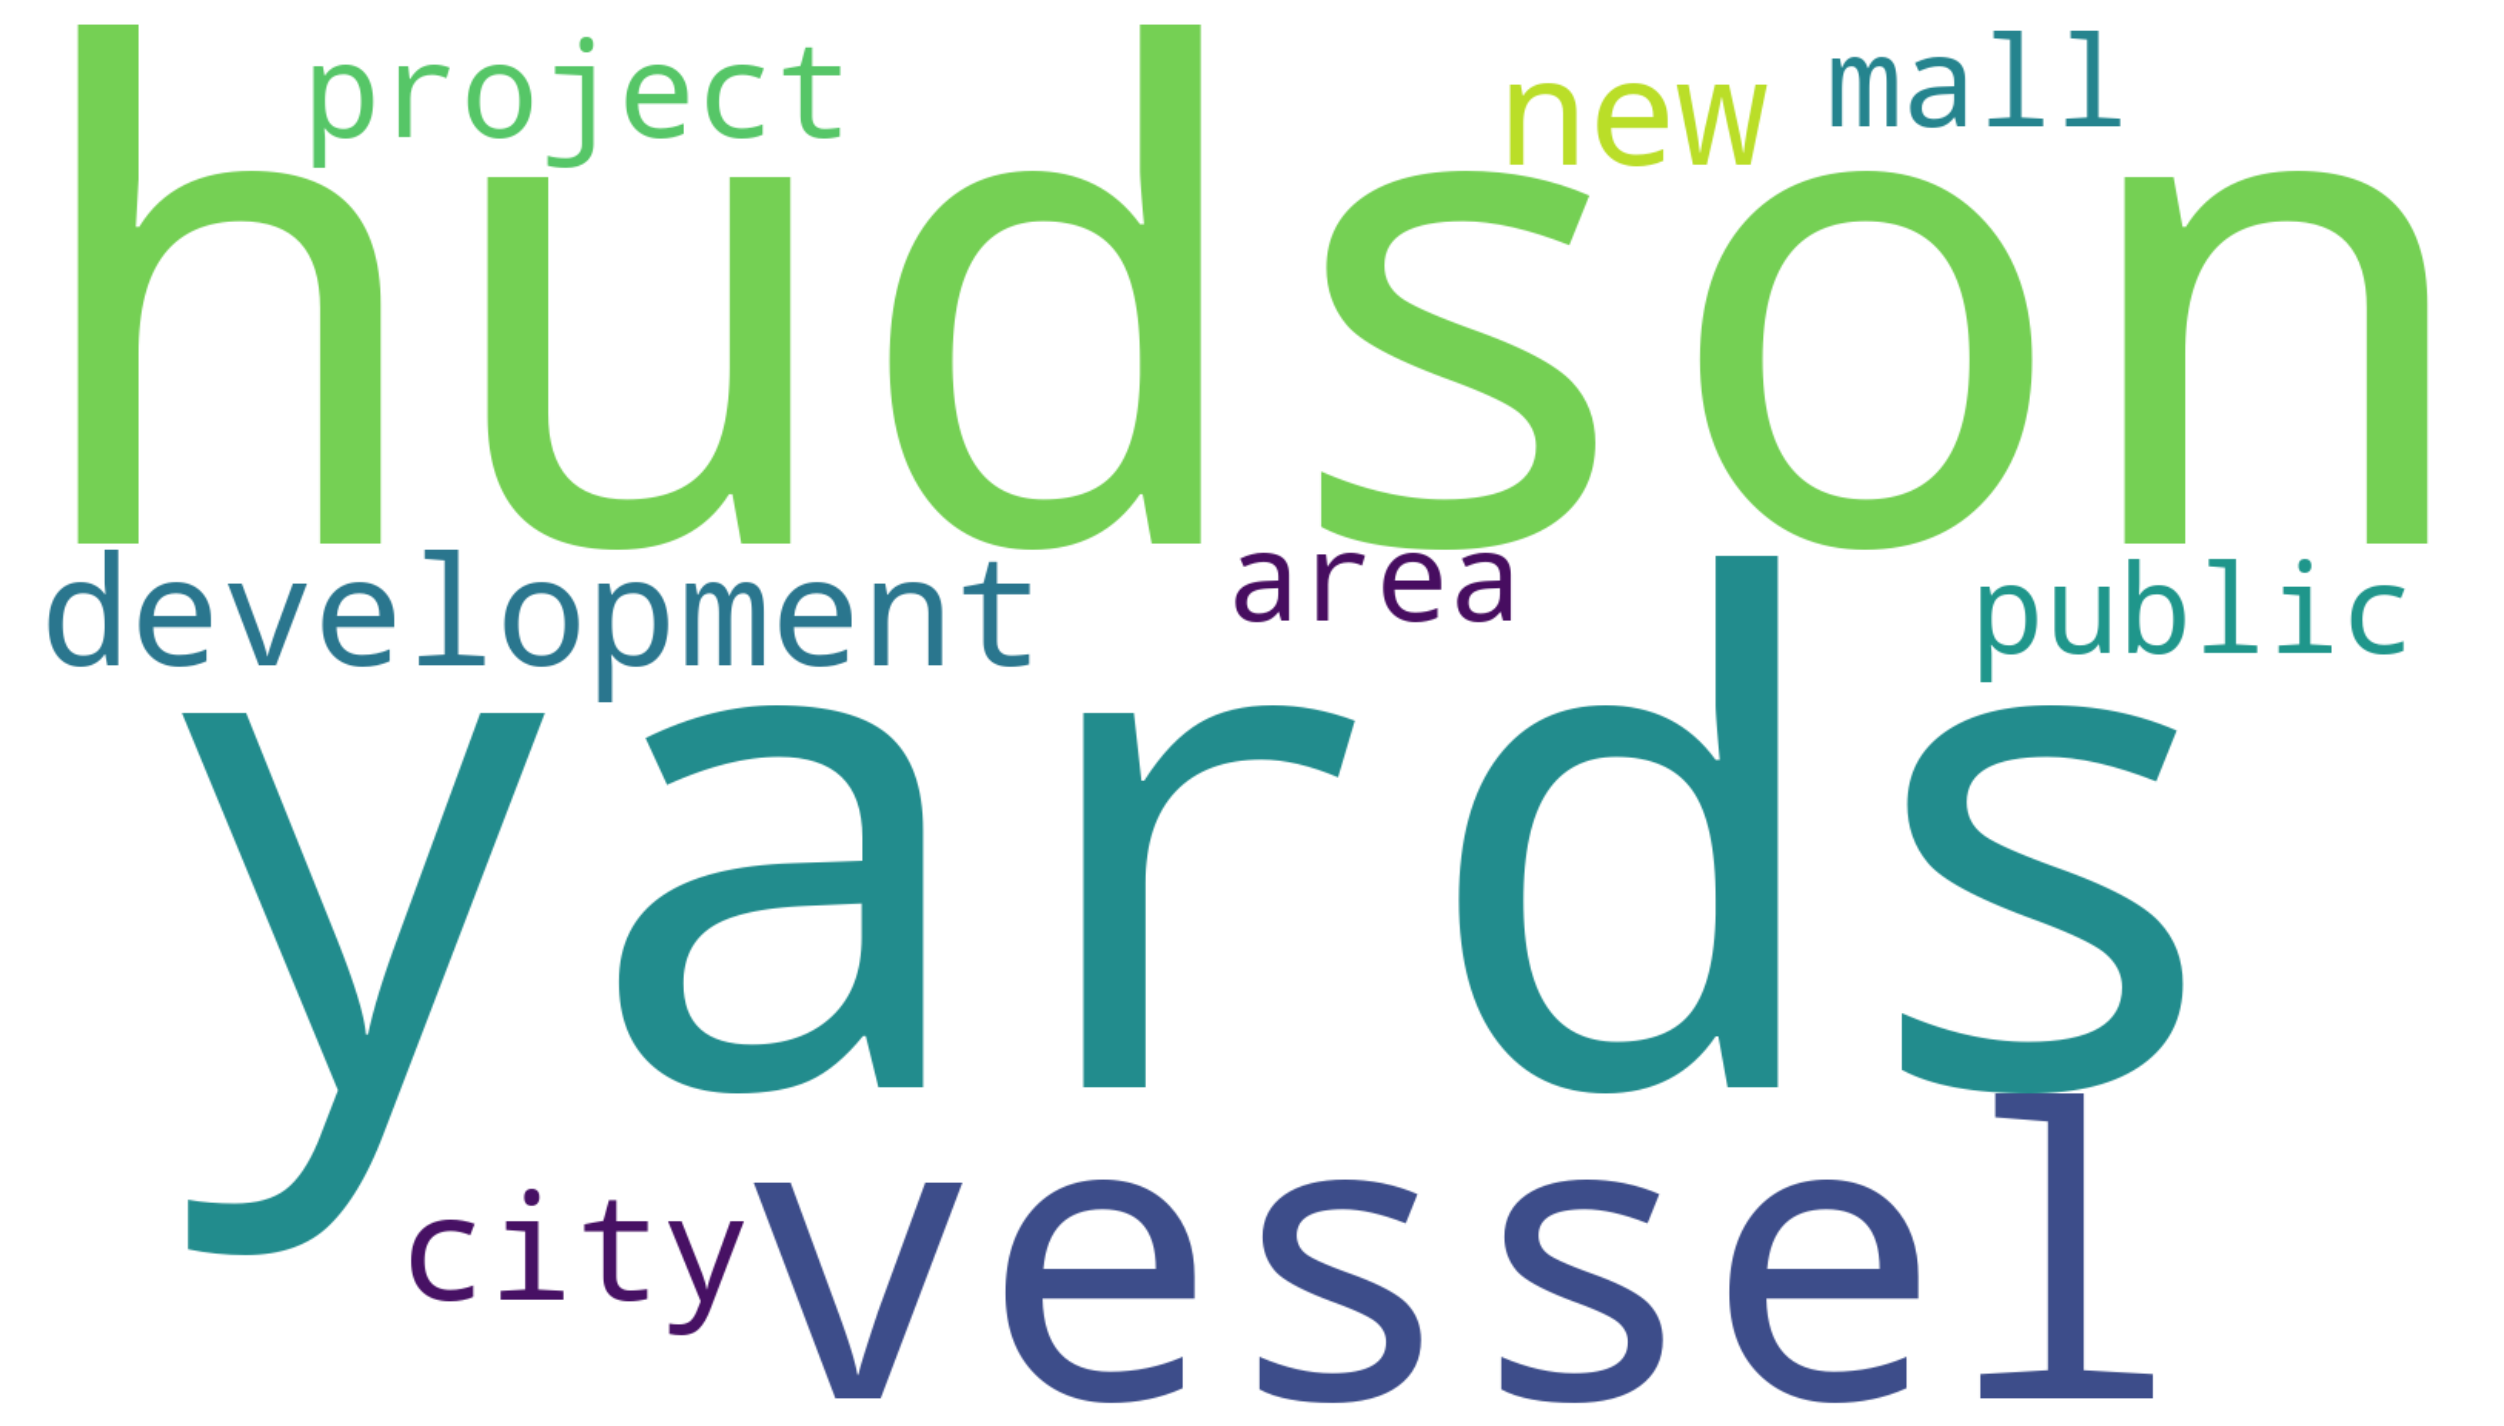

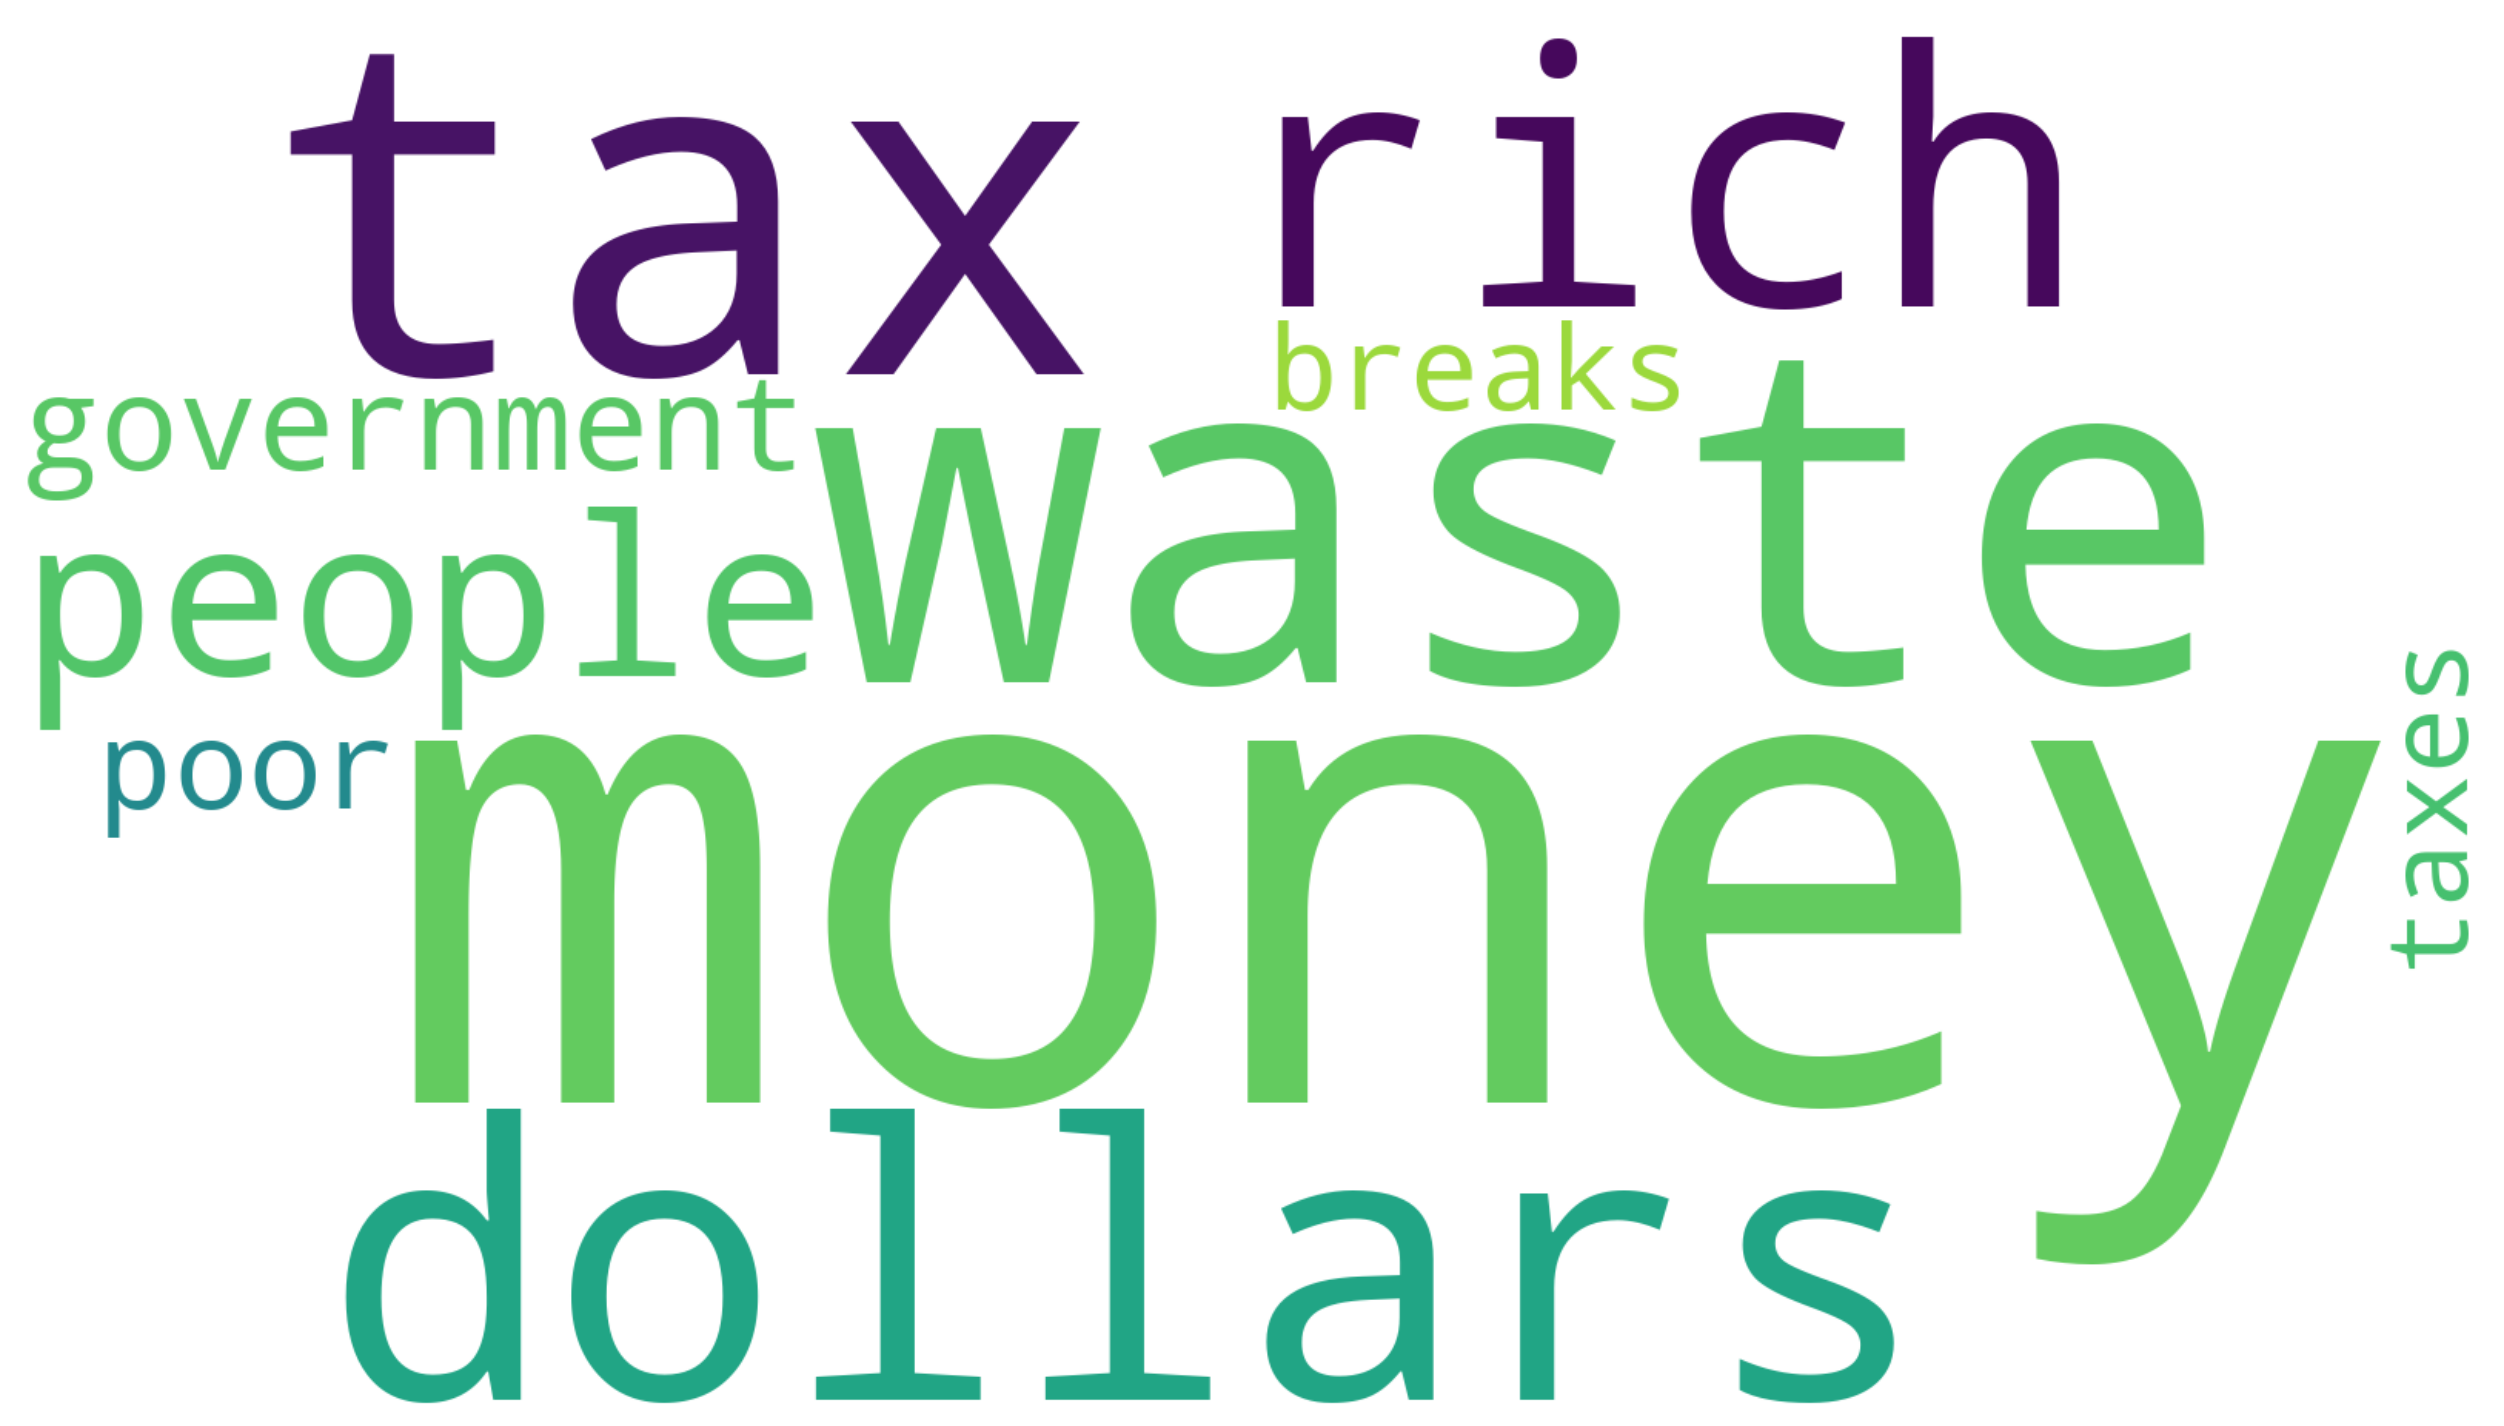

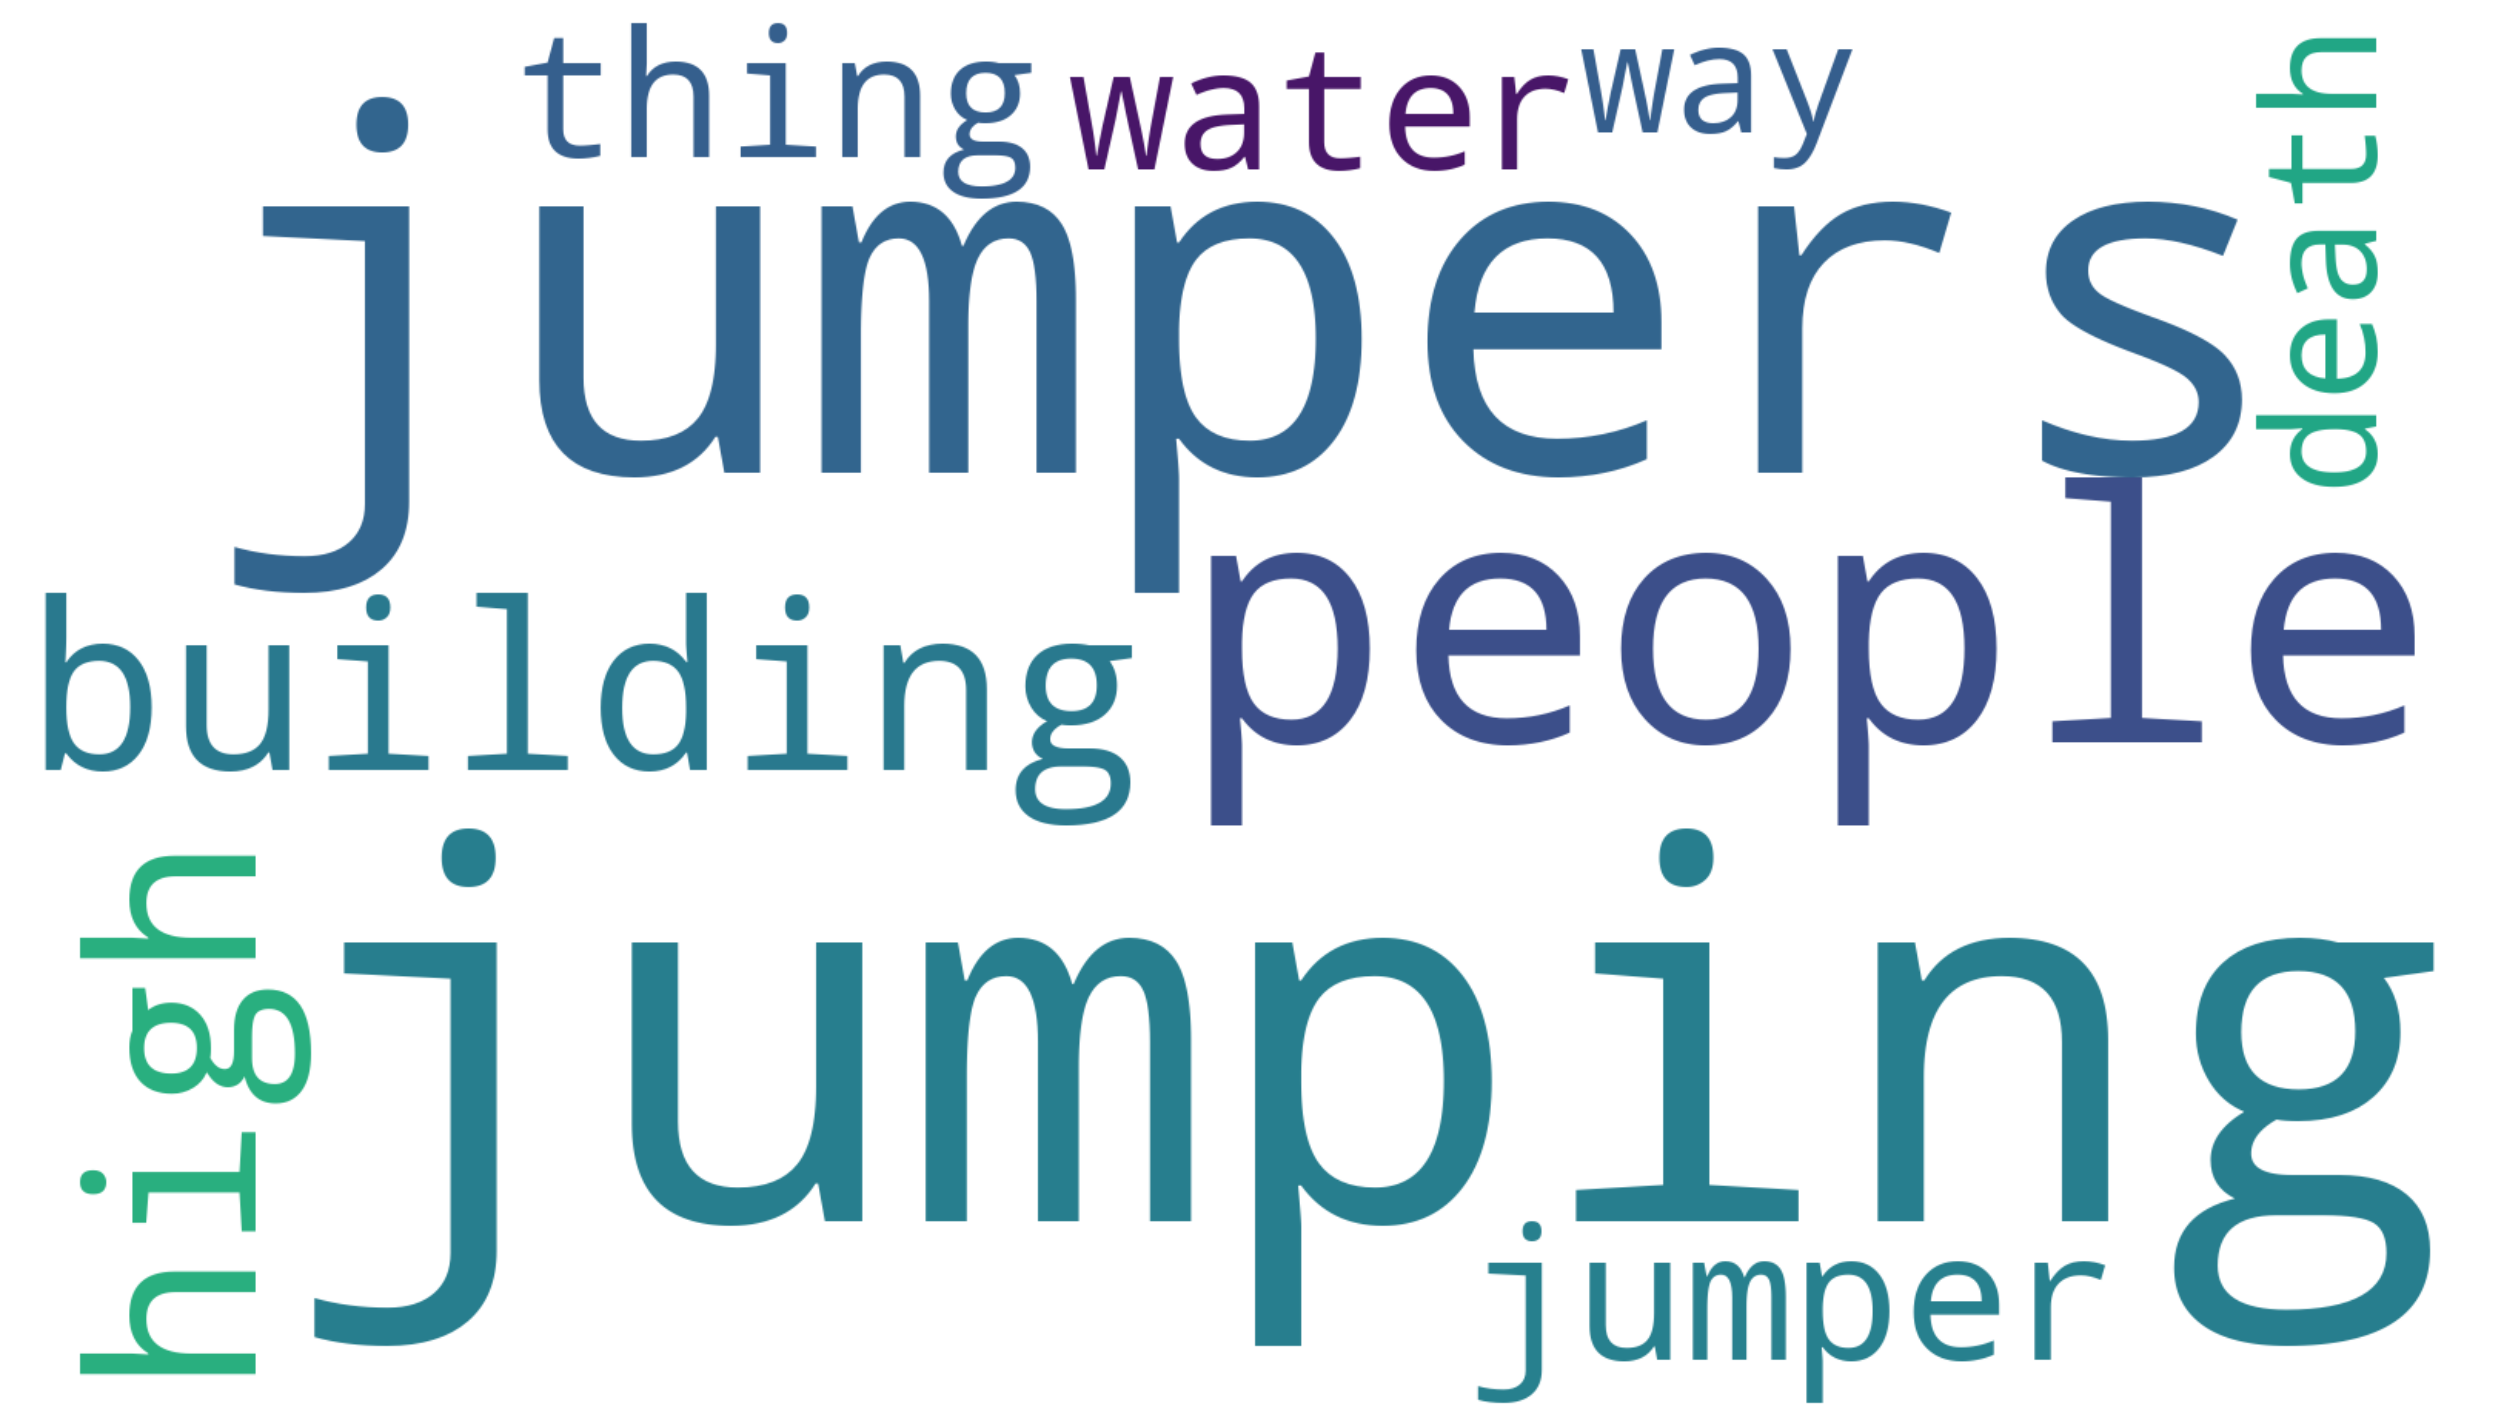

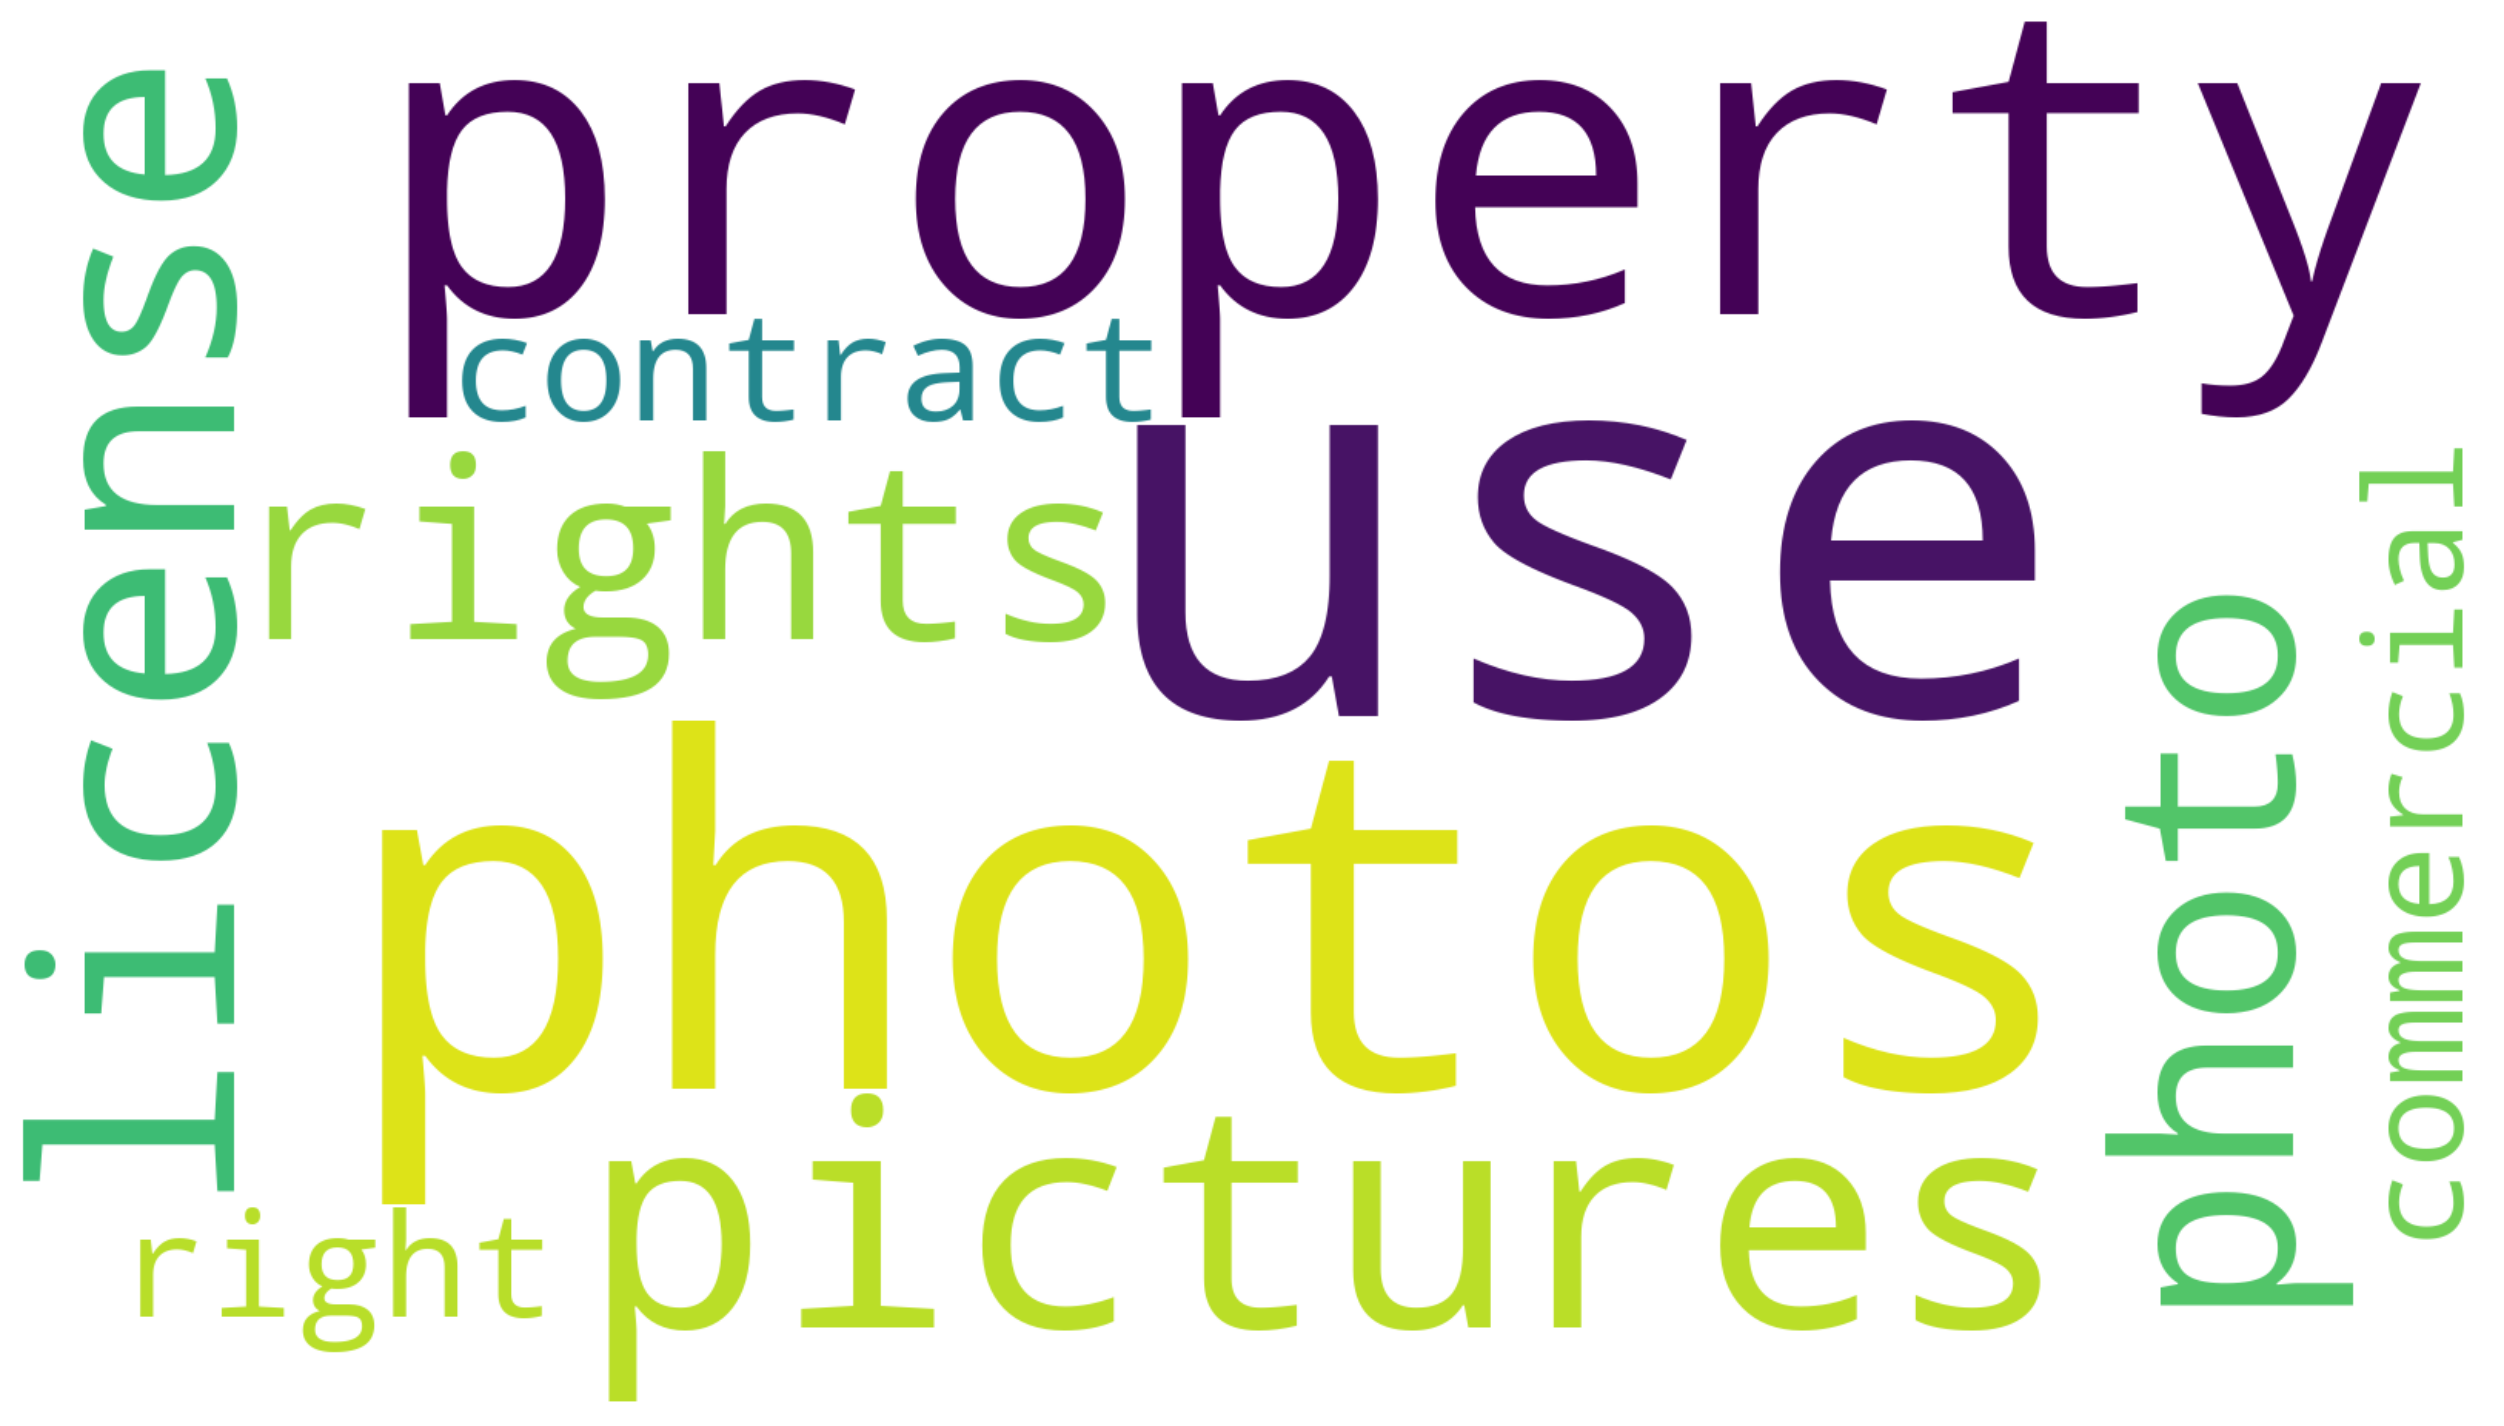

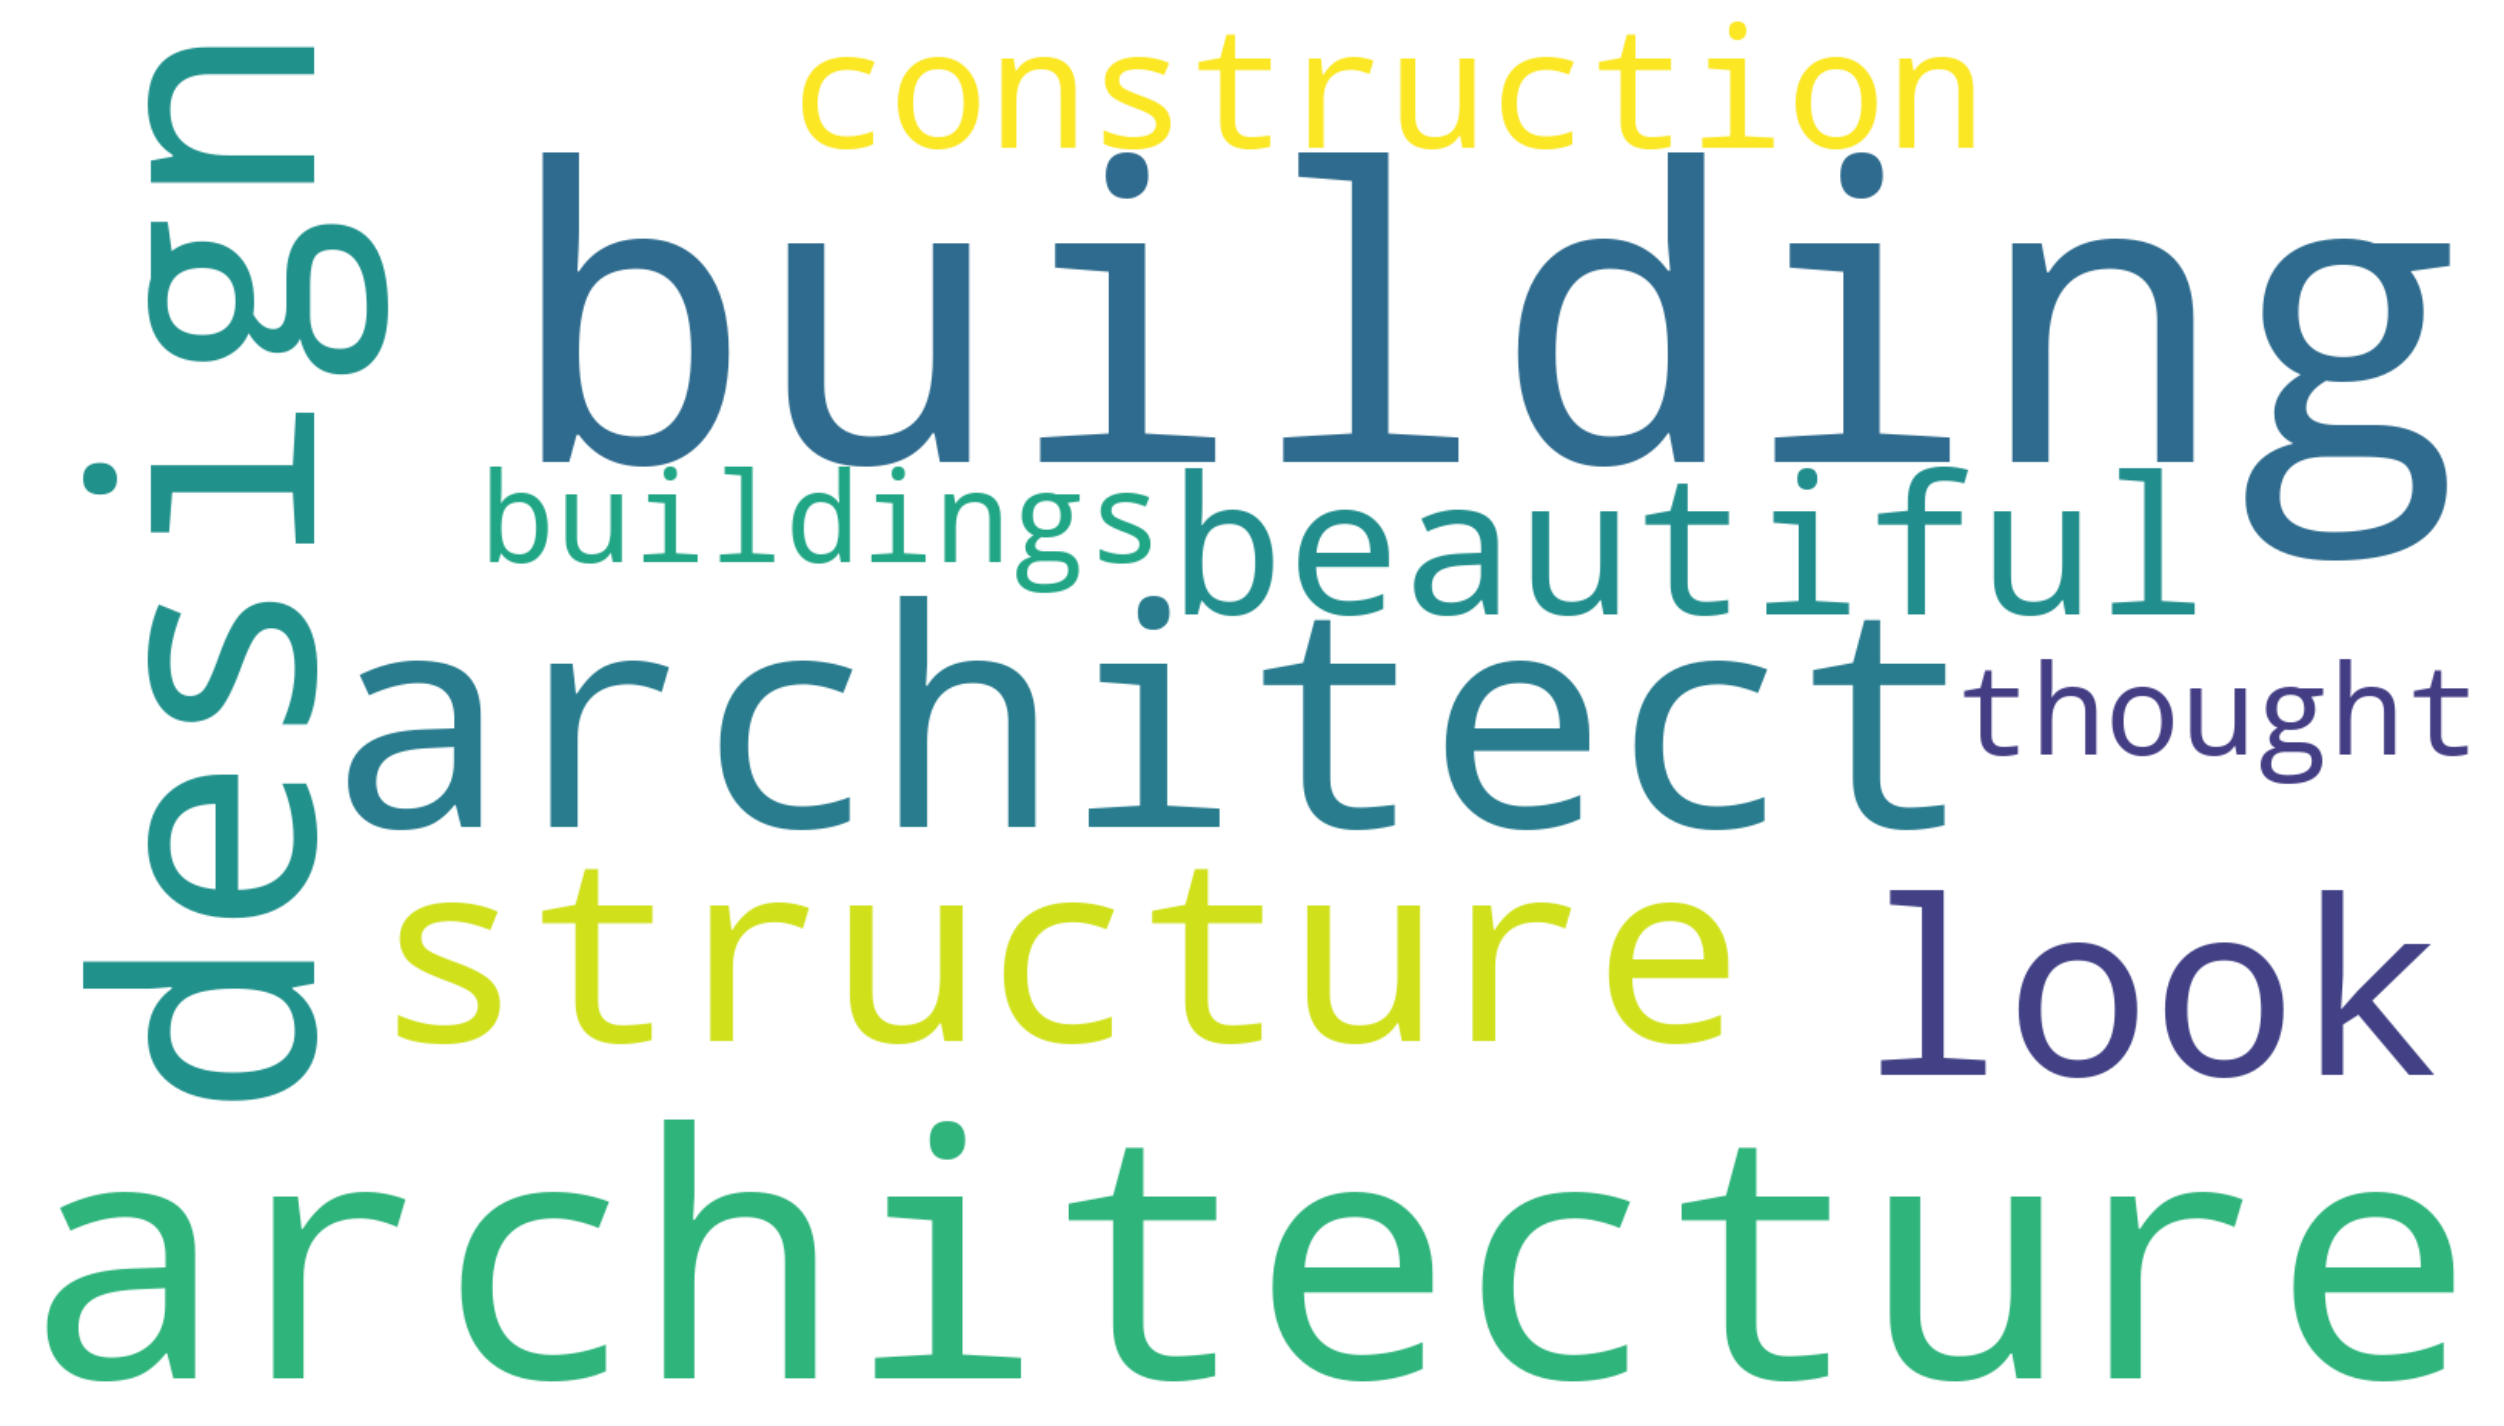

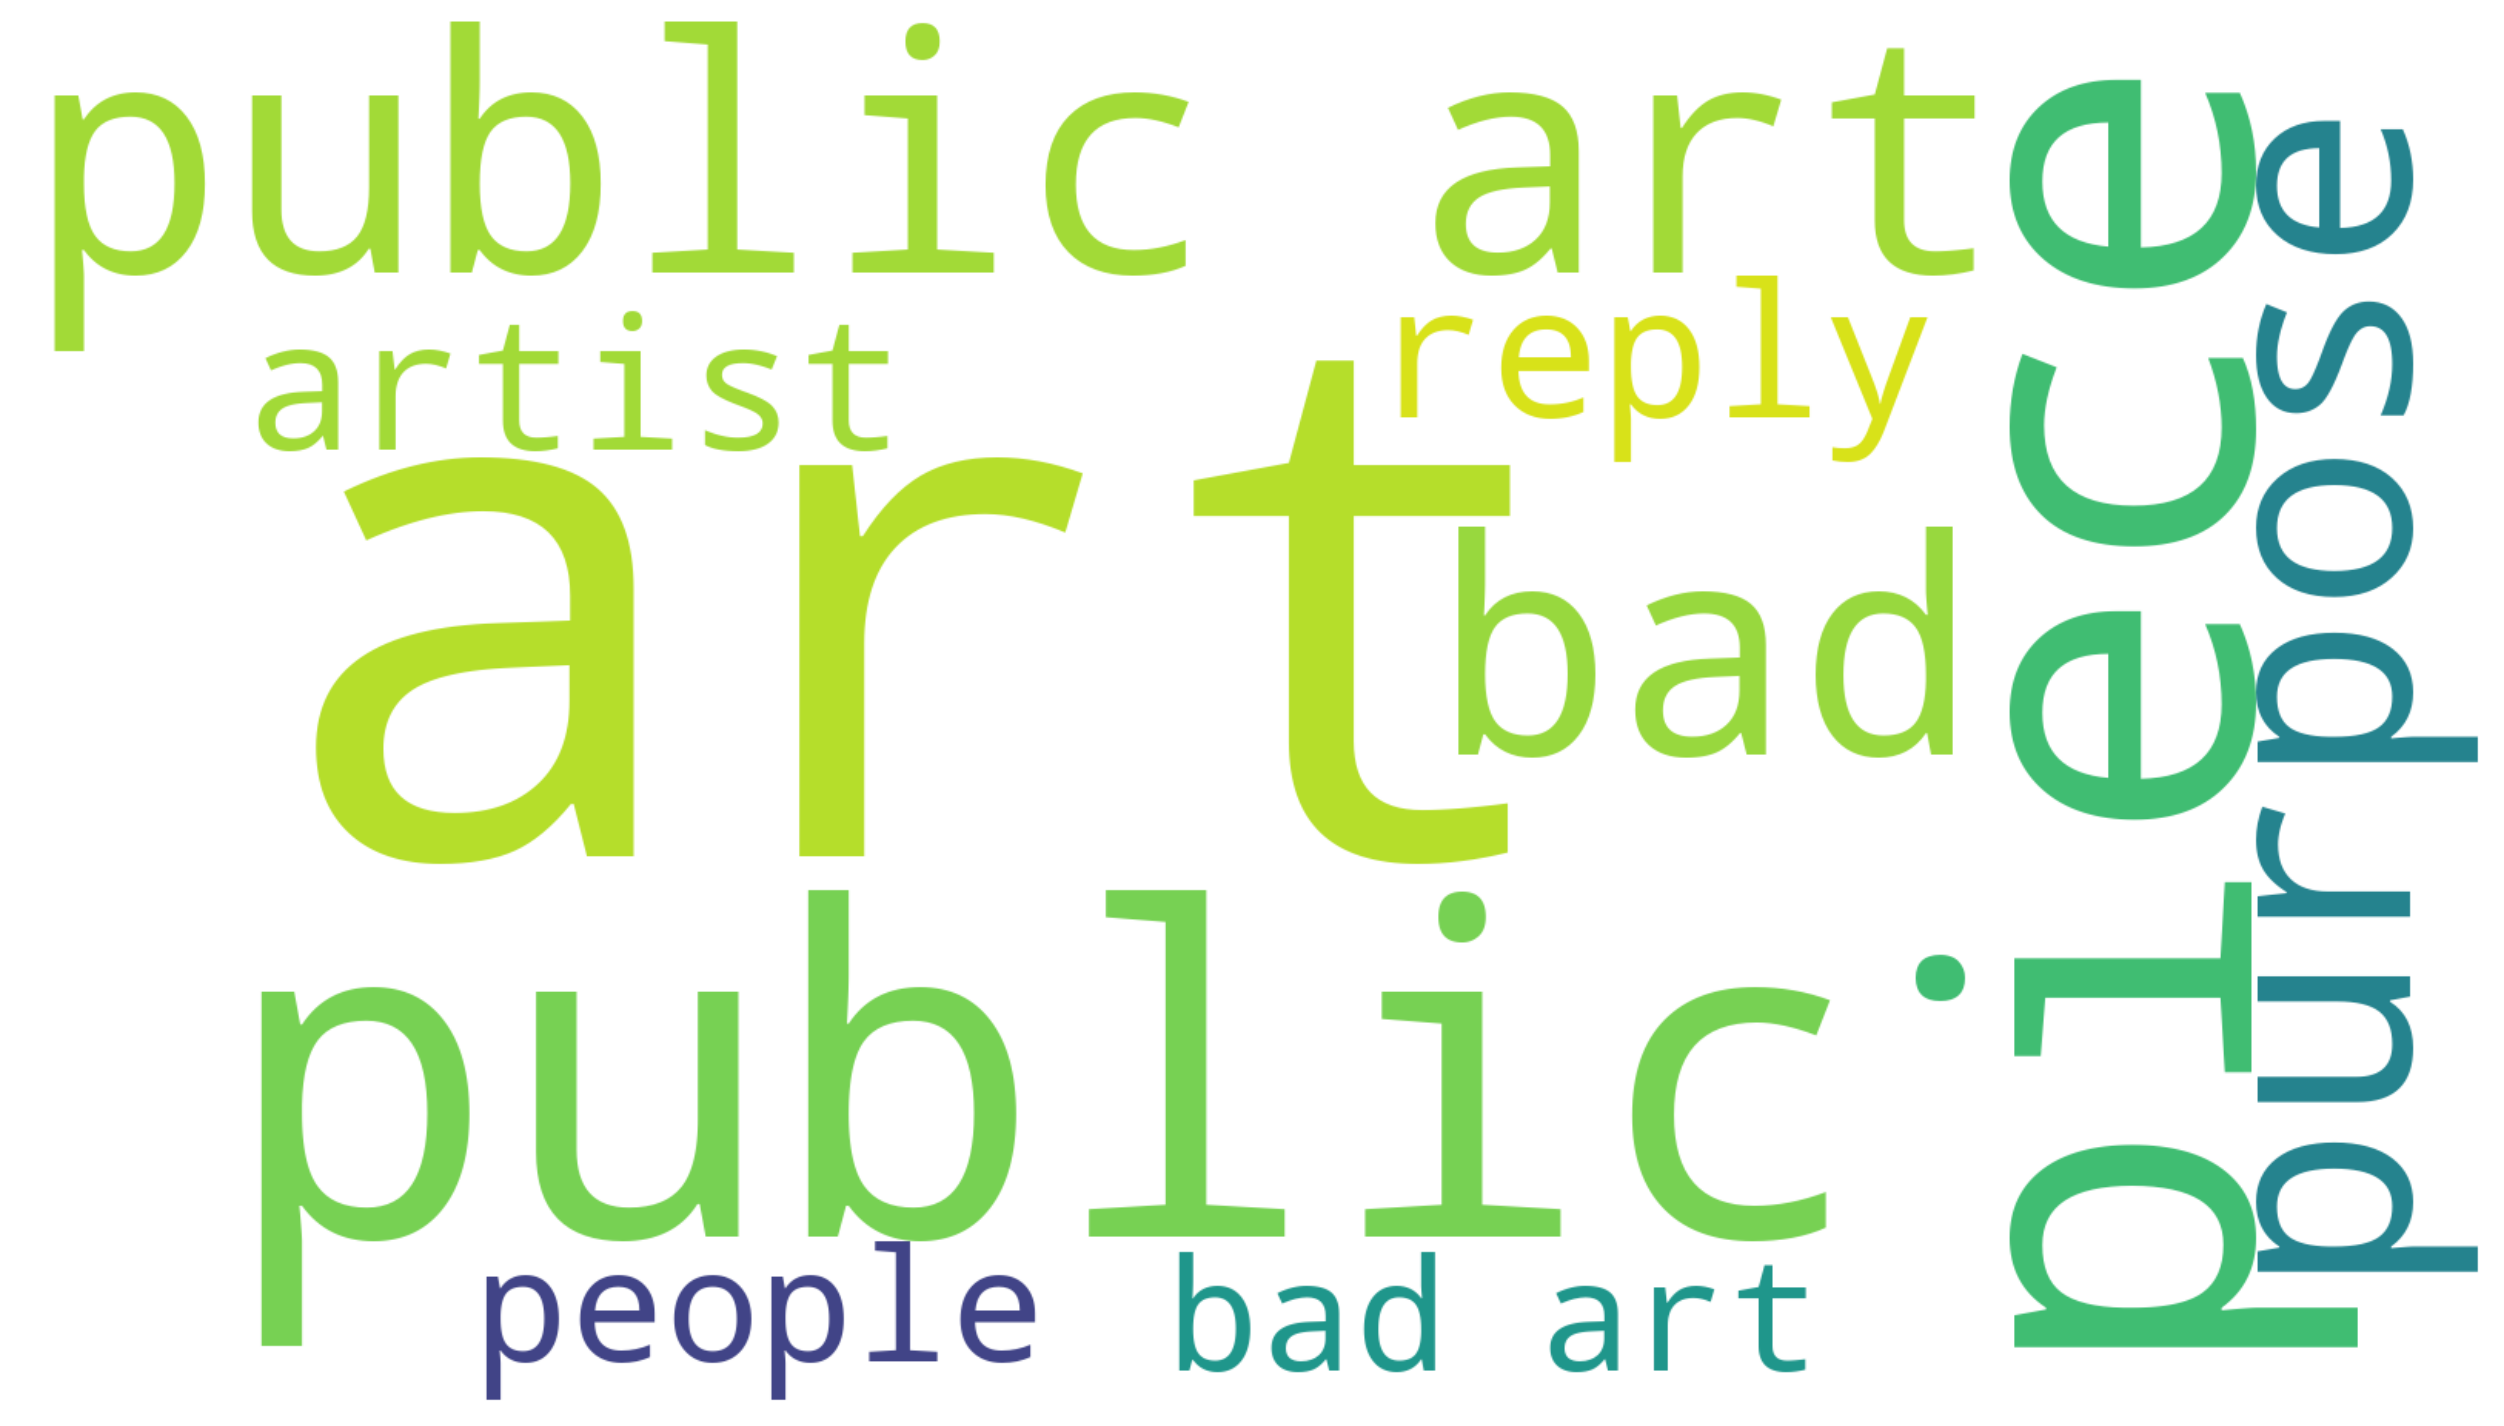

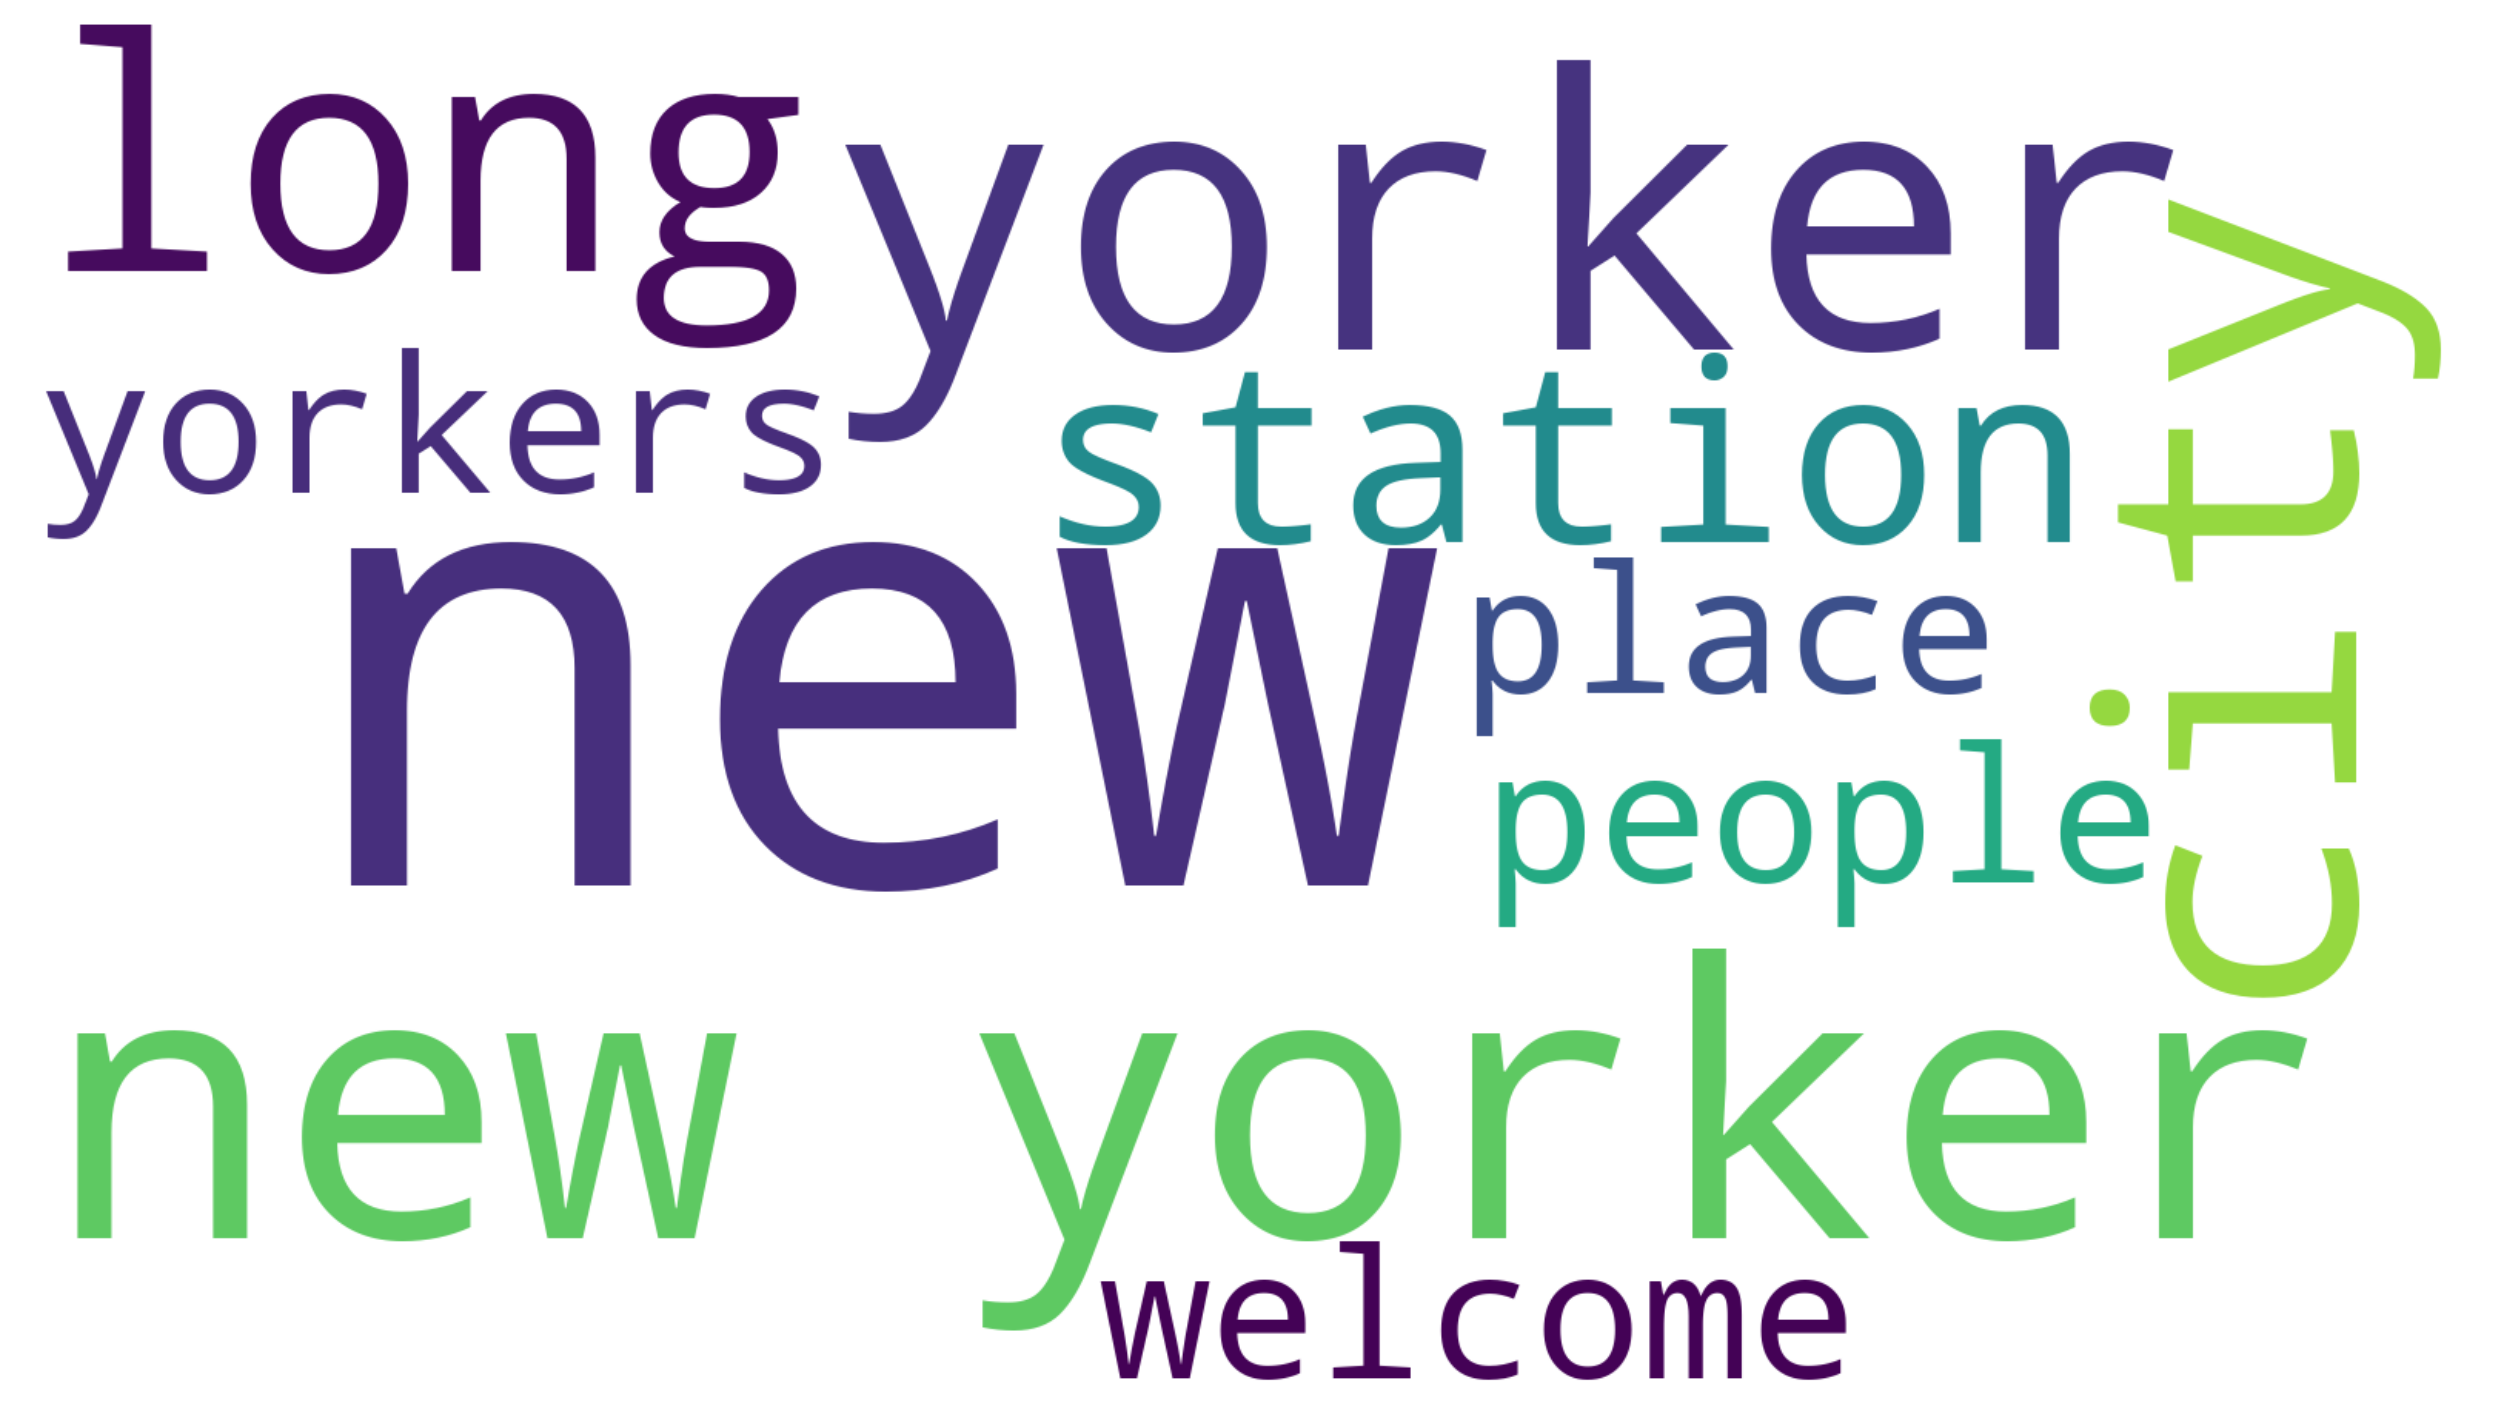

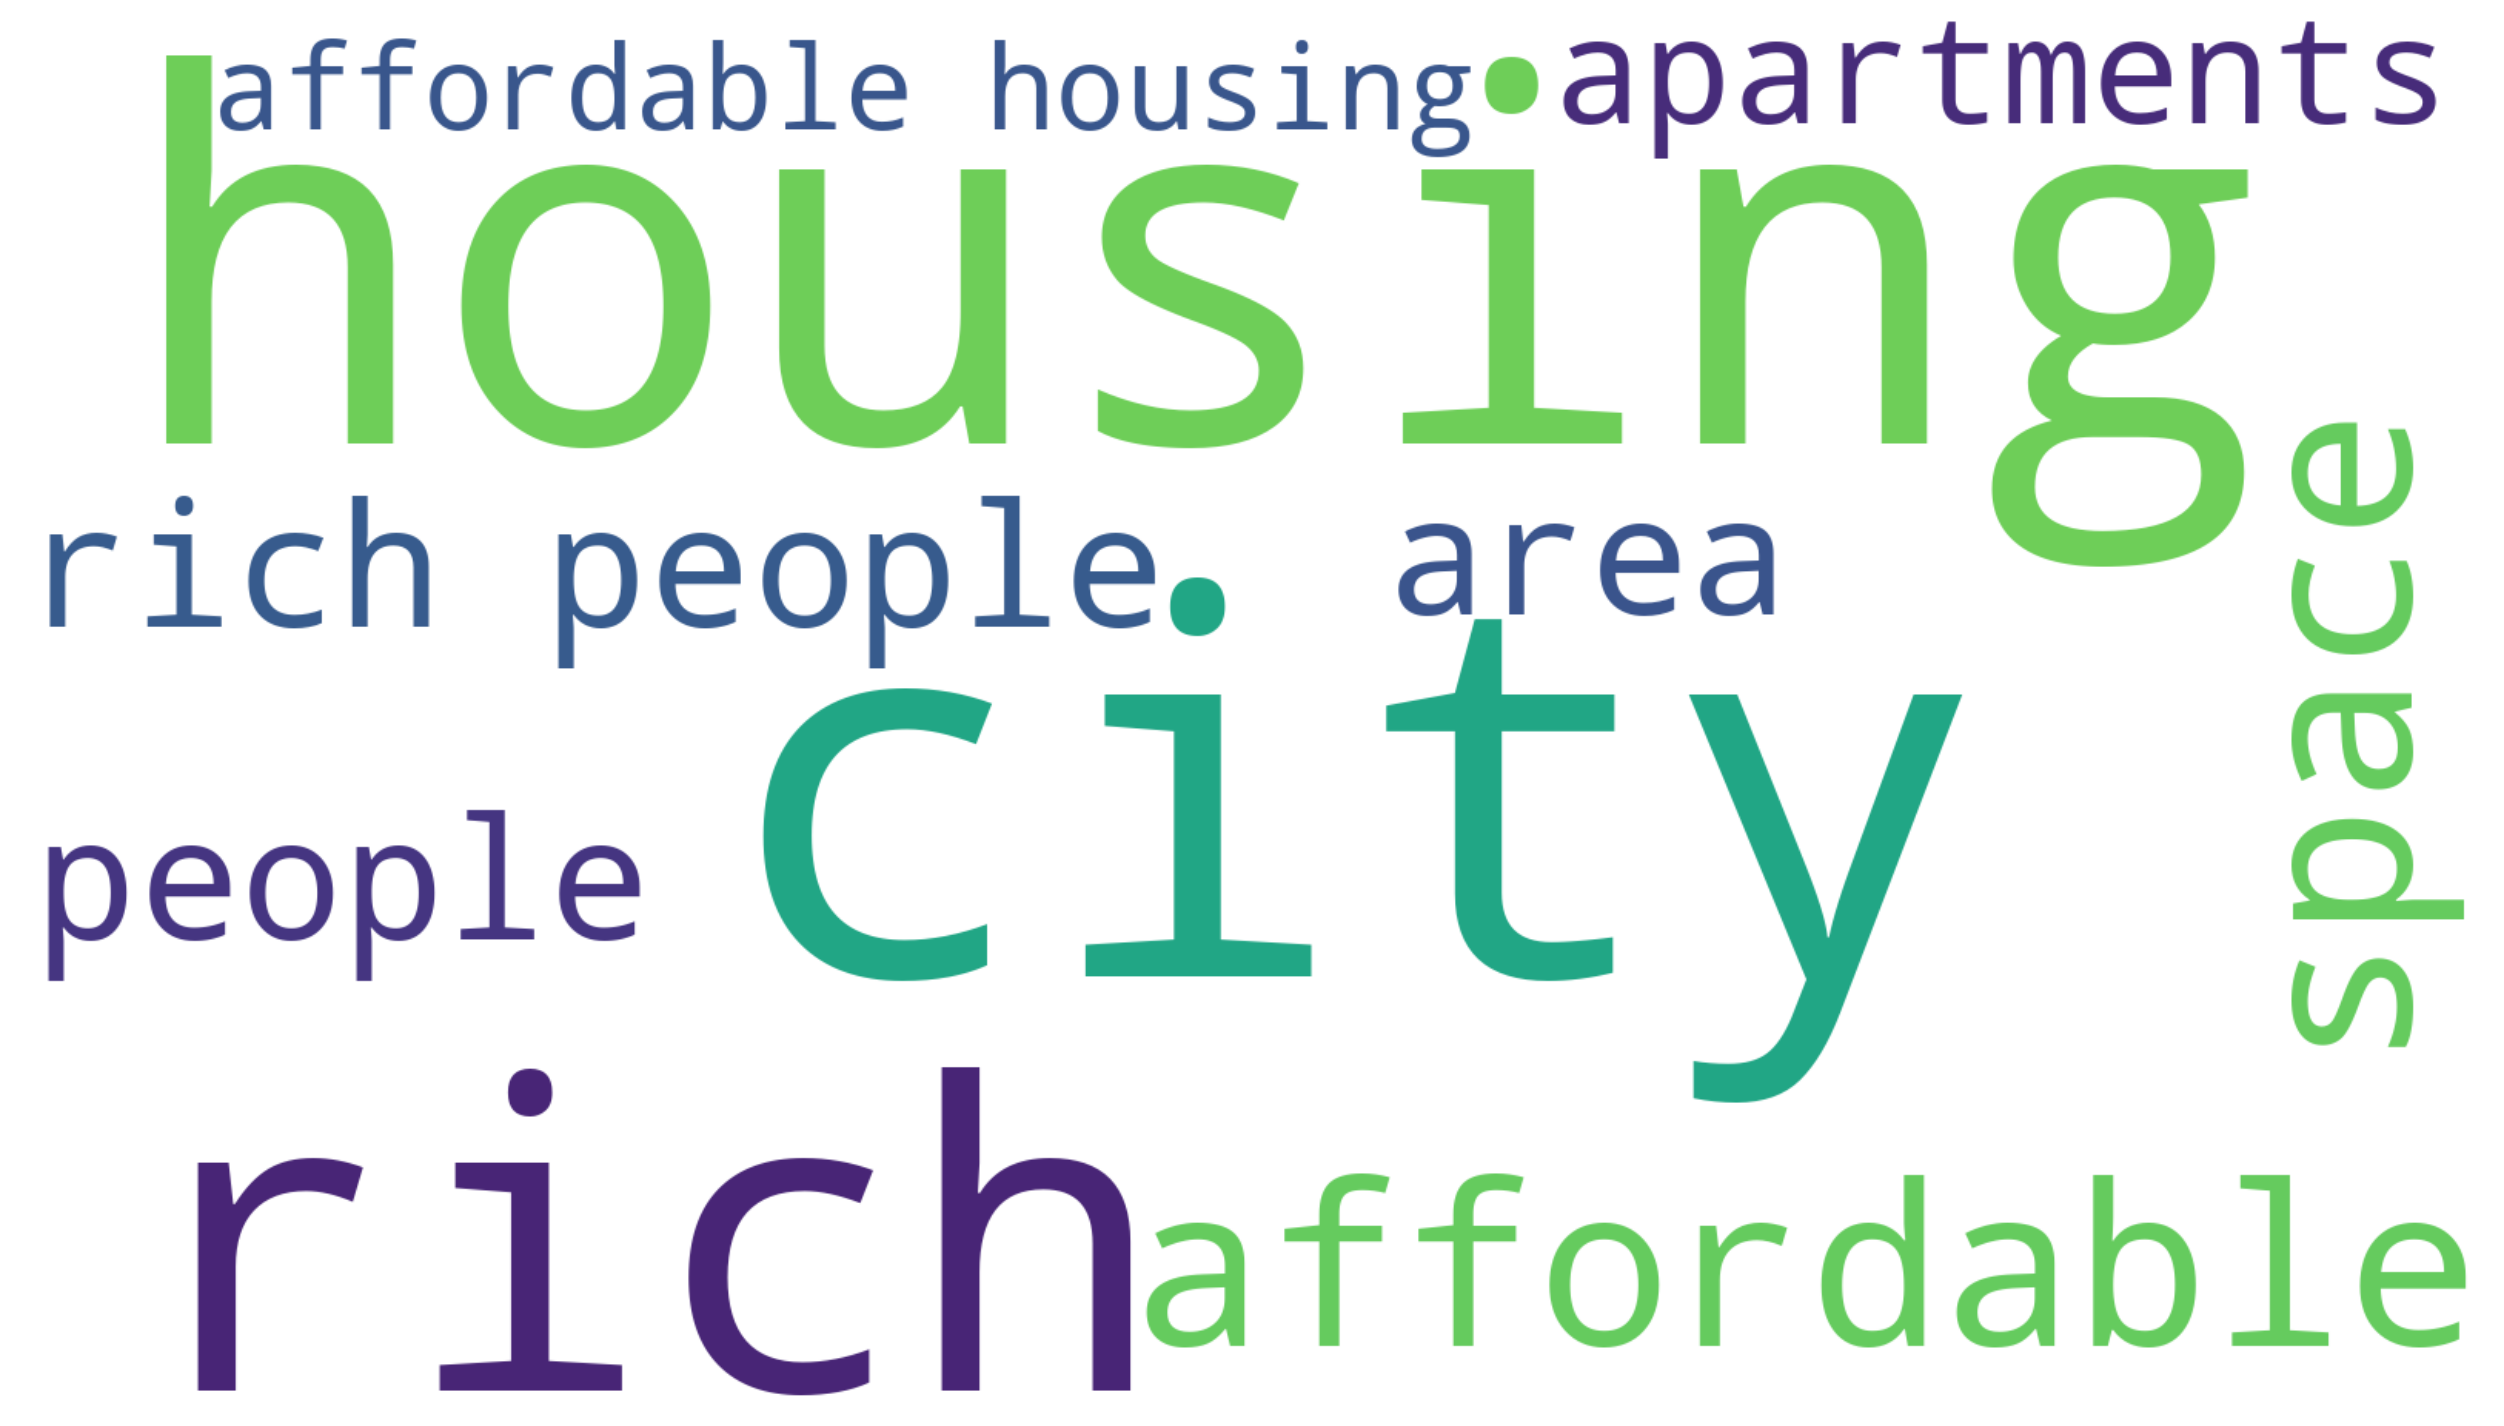

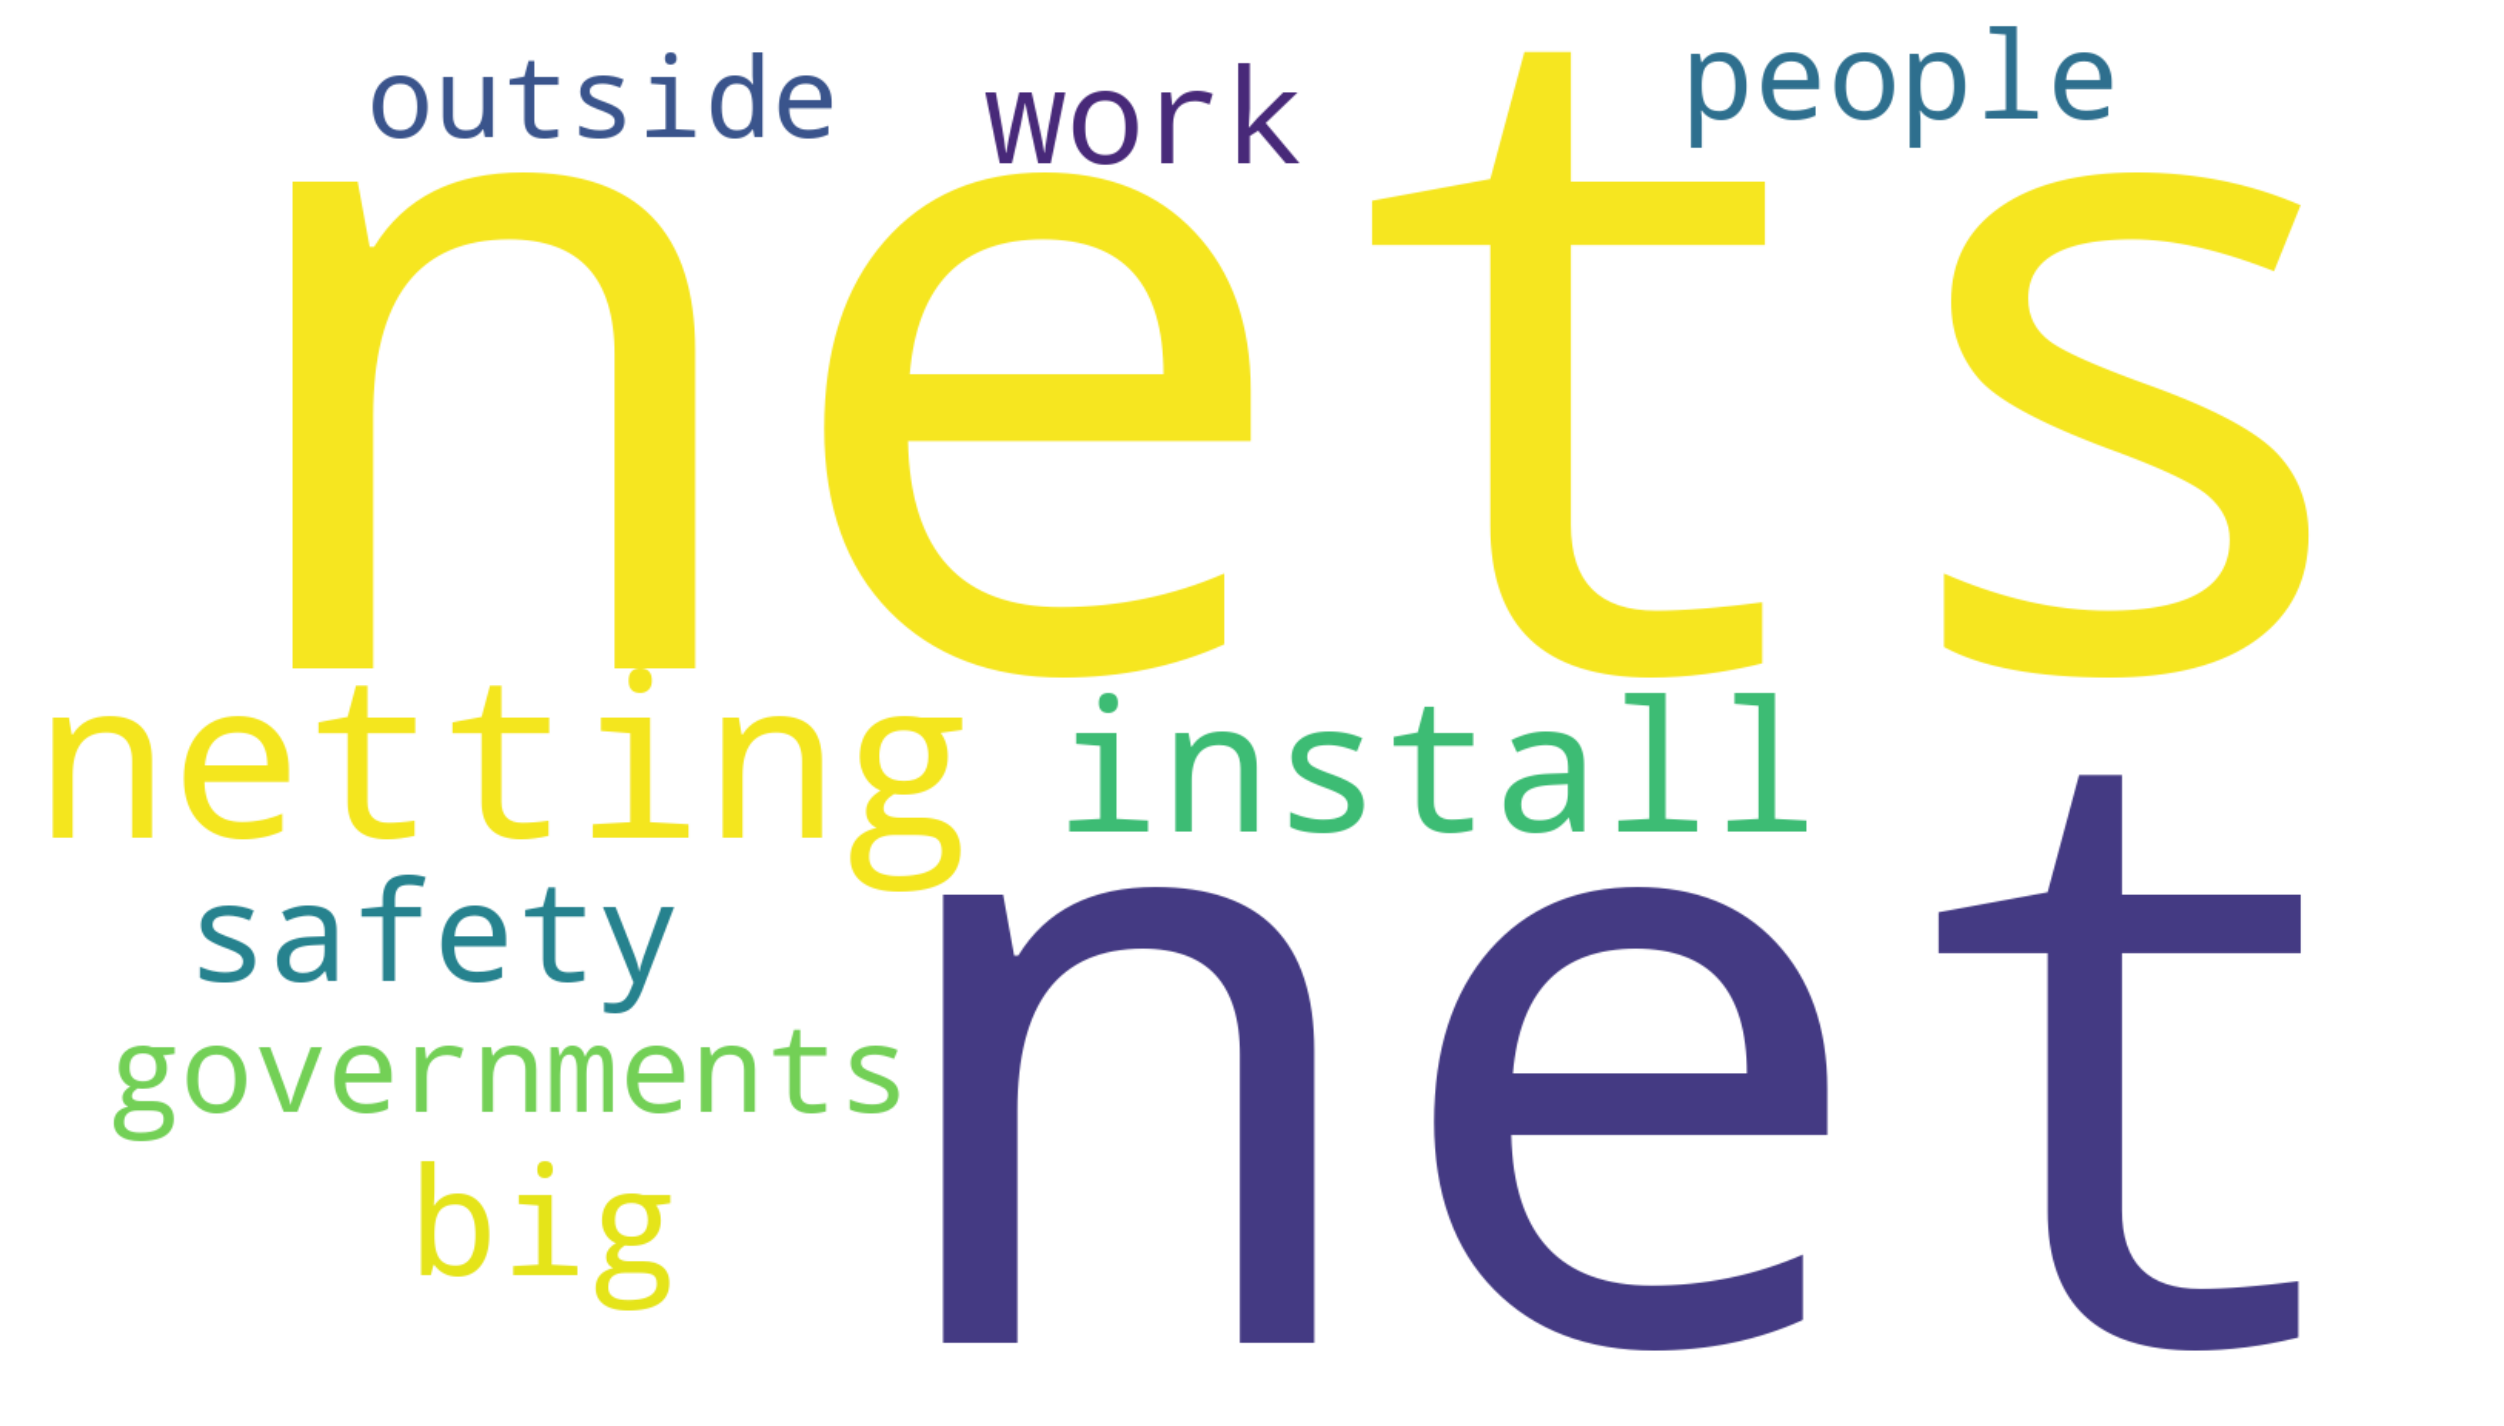

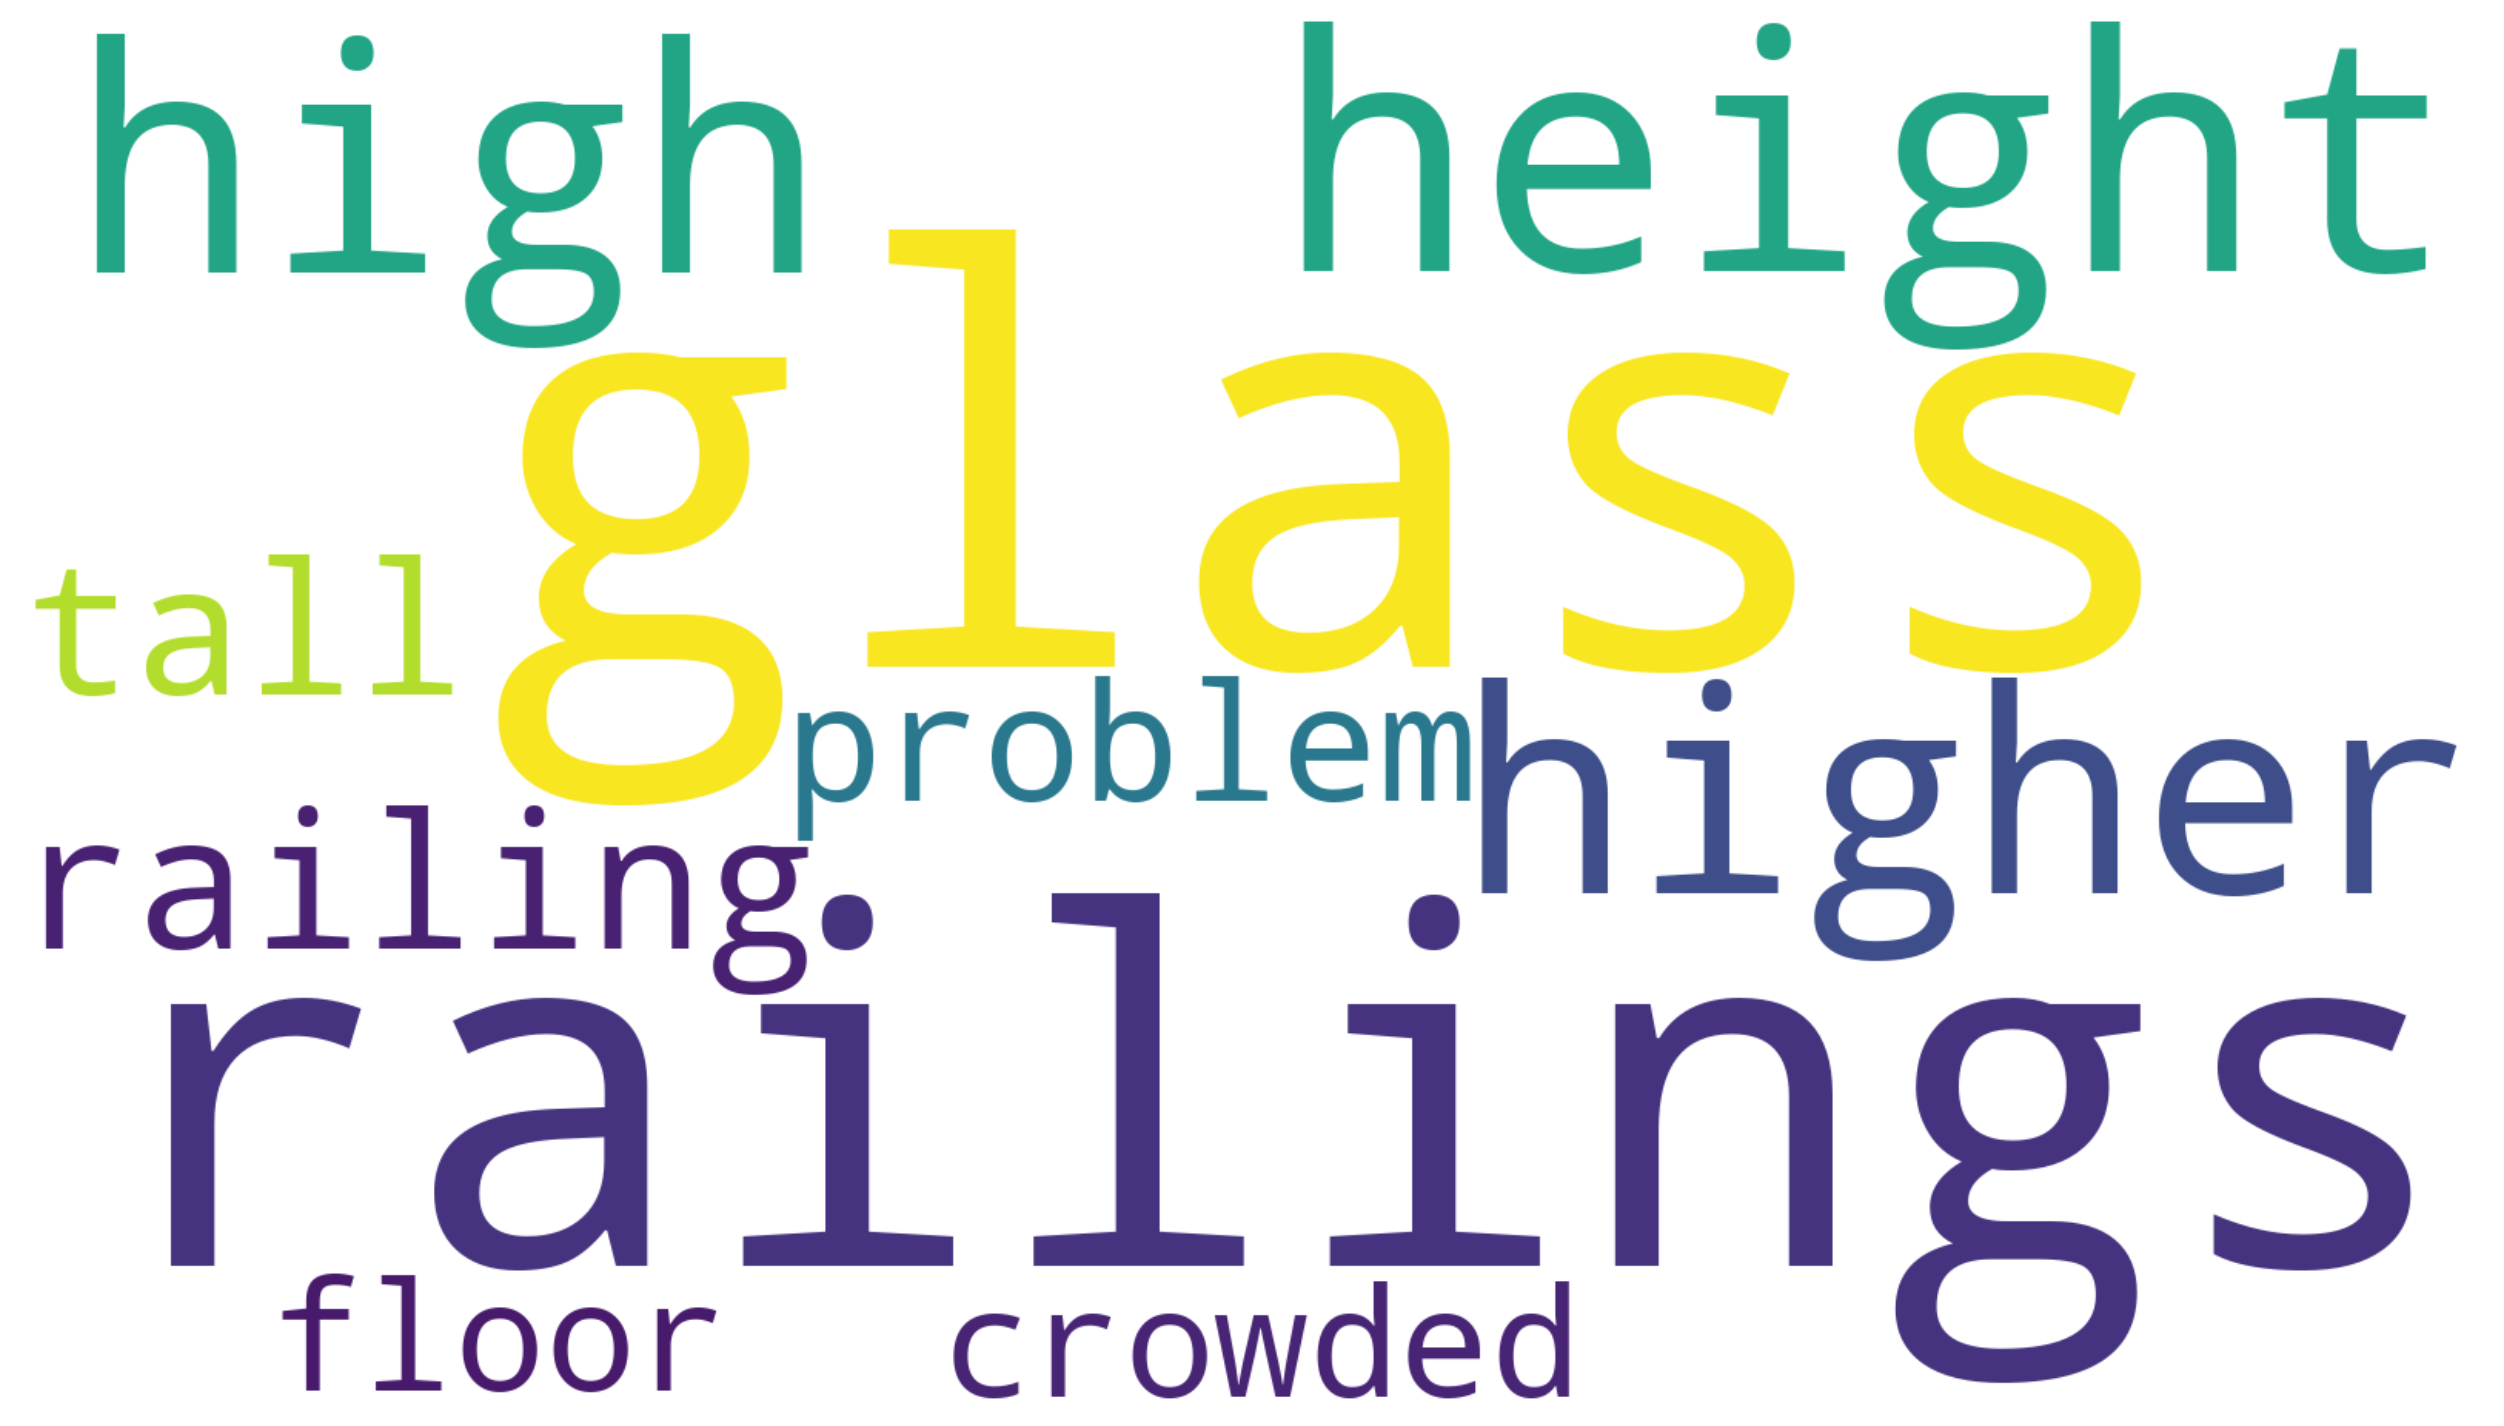

In [43]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud(model, topic):
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(width=1600, height=900,background_color="white")
    wc.generate_from_frequencies(text)
    plt.figure(figsize=(16, 9), dpi=200)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.savefig(f"wordcloud_topic{topic}.png", bbox_inches="tight")  
    plt.show()
    
# Show wordcloud
for topic in range(20):
    create_wordcloud(topic_model, topic)

In [56]:
topic_model.visualize_topics().write_html("visualize_topics_file.html")

In [57]:
fig = topic_model.visualize_heatmap()
fig.write_html("visualize_heatmap.html")

In [58]:
fig = topic_model.visualize_heatmap(width = 1600, height = 1600)
fig.write_html("visualize_heatmap1600.html")

In [60]:
fig = topic_model.visualize_hierarchy()
fig.write_html("visualize_hierarchy.html")



In [61]:
fig = topic_model.visualize_hierarchy(width = 1600, height = 960)
fig.write_html("visualize_hierarchy1600.html")